In [8]:
import gpflow as gp
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_tec.datapack import DataPack
import numpy as np
from bayes_tec.utils.data_utils import calculate_weights, make_coord_array

import warnings
warnings.filterwarnings("ignore")


def gain_solve(datapack, ant_sel=None, time_sel=None,dir_sel=None, pol_sel=slice(0,1,1), freq_sel=slice(0,48,1),
                  flag_dirs=[3,9,10,11,12,16,17,27,31]):
    with DataPack(datapack,readonly=True) as datapack:
        datapack.switch_solset('sol000')
        datapack.select(time=time_sel, ant=ant_sel,pol=pol_sel, dir=dir_sel,freq=freq_sel)
        phase, axes = datapack.phase
        amp, axes = datapack.amplitude
        patch_names, directions = datapack.get_sources(axes['dir'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        timestamps, times = datapack.get_times(axes['time'])
        _,freqs = datapack.get_freqs(axes['freq'])
        select = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))[0]

    gains = amp*np.exp(1j*phase)
    gains = gains[0,select,:,:]
    var = calculate_weights(gains.real,indep_axis=-1, N=4,phase_wrap=False) + calculate_weights(gains.imag,indep_axis=-1, N=4,phase_wrap=False)
    var = var.mean(-2)
    var[...,:2] = var[...,3:4]
    var[...,-2:] = var[..., -3:-2]
    var = np.median(np.median(var, axis=1))

        
    X_t = (times.mjd*86000. - times[0].mjd*86400.)
    X_t = X_t[:,None]
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), 
                  directions.dec.deg - directions.dec.deg.mean()]).T.astype(np.float64)
    X = make_coord_array(X_t, X_d[select,:],flat=True)
    Xstar = make_coord_array(X_t, X_d,flat=True)

    Npol,Nd,Na,Nf,Nt = phase.shape
    Nd_ = len(select)
    #Nt*Nd, Na*Nf
    Y = gains.transpose((3,0,1,2)).reshape((Nt*Nd_,-1))
    Y = np.concatenate([Y.real,Y.imag],axis=1)
    y_mean = Y.mean(0,keepdims=True)
    Y -= y_mean
    y_std = np.mean(Y.std(0,keepdims=True))+1e-8
    Y /= y_std

    var /= y_std**2
    
    with tf.Session(graph=tf.Graph()) as sess:
        with gp.defer_build():
            kernt = gp.kernels.RBF(1,active_dims=slice(0,1,1))
            kernd = gp.kernels.RBF(2,active_dims=slice(1,3,1))
            kernt.lengthscales = 80.
            kernt.lengthscales.transform = gp.transforms.positiveRescale(80.)
            kernd.lengthscales = 1.
            kernt.variance = 0.7
            kernt.variance.transform = gp.transforms.positiveRescale(0.75)
            kernd.variance.trainable = False
            kern = kernt*kernd
            m = gp.models.GPR(X.astype(np.float64),Y.astype(np.float64),kern)
            m.likelihood.variance = var
            m.likelihood.variance.trainable = False
            m.compile()
#         gp.train.ScipyOptimizer().minimize(m)
#         print(m)
        ystar,varstar = m.predict_y(Xstar.astype(np.float64))
    ystar = (ystar * y_std + y_mean)
    real = ystar[:,:Na*Nf].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    imag = ystar[:,Na*Nf:].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    gstar = real + 1j*imag
    varstar = varstar * y_std**2
    real = varstar[:, :Na*Nf].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    imag = varstar[:, Na*Nf:].reshape((Nt,Nd,Na,Nf)).transpose((1,2,3,0))
    gvarstar = real + 1j*imag
    
    return gstar, gvarstar

def get_freq_weights(gains, freqs):
    tec_conv = -8.448e9/freqs
    
    with tf.Session(graph=tf.Graph()) as sess:
        phi_pl = tf.placeholder(tf.float64)
        tec_conv_pl = tf.placeholder(tf.float64)
        log_w = tf.Variable(np.zeros(len(freqs)),dtype=tf.float64)
        w = tf.exp(log_w)
        w /= tf.reduce_sum(w)

        dtec = phi_pl / tec_conv_pl[:,None]
        dtec_mu = tf.reduce_sum(dtec*w[:,None],axis=-2)

        dtec_var = tf.reduce_sum(dtec**2*w[:,None],axis=-2) - dtec_mu**2

        loss = tf.reduce_mean(dtec_var)# + tf.reduce_sum(tf.abs(w_))

        opt = tf.train.AdamOptimizer(1e-3).minimize(loss,var_list=[log_w])
        init = tf.global_variables_initializer()
        sess.run(init)
        for i in range(1000):
            _, loss_, w_ = sess.run([opt, loss, w], feed_dict={phi_pl:np.angle(gains), tec_conv_pl:tec_conv})
        return w_
            
            

In [2]:
import seaborn as sns
import pylab as plt
import pandas as pd
from bayes_tec.utils.data_utils import define_equal_subsets
import os
from timeit import default_timer

max_block_size, min_overlap = 50, 0

with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=False) as datapack:
    datapack.select(time=None, ant=None)
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    timestamps, times = datapack.get_times(axes['time'])
    _,freqs = datapack.get_freqs(axes['freq'])
    pol_labels,pols = datapack.get_pols(axes['pol'])
    
datapack.switch_solset('posterior_sol', 
            array_file=DataPack.lofar_array, 
            directions = np.stack([directions.ra.rad,directions.dec.rad],axis=1), patch_names=patch_names)
datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)
datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    
Nt = len(times)
solve_slices, _, _ = define_equal_subsets(Nt,max_block_size, min_overlap)

t0 = default_timer()
for i in range(1,62,1):
    ant = antenna_labels[i]
    print(ant)
    for j, solve_slice in enumerate(solve_slices):
        time_slice = slice(*solve_slice, 1)
        gstar, gvarstar = gain_solve('../../scripts/data/killms_datapack_4.hdf5', 
                                   ant_sel=slice(i,i+1,1), time_sel=time_slice, dir_sel=None, 
                                   pol_sel=slice(0,1,1), freq_sel=slice(0,48,1),
                               flag_dirs=[3,9,10,11,12,16,17,27,31])
        with datapack:
            datapack.switch_solset('posterior_sol')
            datapack.select(ant=slice(i,i+1,1),time=time_slice,dir=None,pol=slice(0,1,1), freq=slice(0,48,1))
            datapack.phase = np.angle(gstar[None,...])
            datapack.amplitude = np.abs(gstar[None,...])
        t1 = default_timer()
        num_left = len(solve_slices)*61 - j - (i-1)*len(solve_slices) - 1
        rate = (t1-t0)/(1 + j + (i-1) * len(solve_slices))
        print("Time left: {} s".format(num_left*rate))
        

ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


b'CS001HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4880.556935647037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4934.942377209081 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4916.86017198069 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4984.9887495425355 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4910.153794939397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4879.42891166691 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4902.901839390663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4883.857151566888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4860.495109666526 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4876.8365491754375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4884.031773116524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4934.2691745443735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4917.798026267995 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4905.976785417338 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4906.273702550679 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4890.046350402095 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4881.953511165236 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4892.6524740670575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4879.311872273805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4881.97384454959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4879.094736667217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4875.39620339545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4891.270298127166 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4884.910617950969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4880.177408121061 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4886.941465838732 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4879.335705778459 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4886.196617202618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4883.094912851559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4932.570210175704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5477.5114937640965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5961.054257578406 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6417.786085387311 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6869.825441686262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7268.613358748079 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7672.915284947939 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8042.878781529402 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8372.448118946273 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8715.359590872335 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9020.526302508253 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9301.794396023488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9631.873202495142 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9901.43236516336 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10183.627073104244 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10432.889277377242 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10681.097440570571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10914.03632803729 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 11079.55548221479 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 11036.654552169743 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10989.140651611611 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10931.175126007922 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10878.467335679861 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10825.035277669796 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10766.94493606644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10713.105777708306 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10654.7195742583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10599.82076144058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10550.493409191133 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10492.771933142853 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10437.952923591627 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10380.051598036196 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10320.260701509287 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10268.414513072088 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10212.446578257968 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10155.697104013167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10107.31259329353 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10052.657551355167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10002.879359161348 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9953.411927859966 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9914.435298181937 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9922.016647472912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9985.36566477675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10026.362917712235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10056.076390556875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10063.012021144385 s
b'CS002HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10044.619046022844 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9988.420243267194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9933.45385688546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9886.427232333164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9834.454240882464 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9785.215679598396 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9737.406870769993 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9687.278830422261 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9641.840536903772 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9594.427764422015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9546.836511747977 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9505.734792726693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9467.458175444435 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9423.03481853859 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9382.549544790778 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9338.510990454392 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9298.224343078291 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9256.24973035434 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9214.549817233055 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9176.467038123232 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9136.69342327294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9096.551885665533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9059.542781542572 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 9020.221715915242 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8984.567445873137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8946.874029707747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8909.479518444585 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8875.861845043966 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8842.970531333362 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8810.127567762942 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8777.255254588295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8748.188251033887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8722.540251999932 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8696.067476459004 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8671.971951378546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8648.897982078026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8622.609029086132 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8591.552683282265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8562.533664617313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8533.737587220297 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8506.59269275222 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8478.625289232941 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8455.345189411077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8433.855737682448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8410.882962550051 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8387.243589930846 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8364.879111171293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8335.991634947055 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8309.734796082314 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8282.787124038161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8254.98120061225 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8229.803739114364 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8202.872700522275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8176.530880485071 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8152.561884680535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8127.023190890027 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8105.909351682648 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8081.939038577162 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8058.227244158873 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8036.676661532476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8013.931633227251 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7991.837966737757 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7972.015953517918 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7951.540740992167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7934.019117741325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7915.186509885954 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7896.0651347563 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7880.4173714789085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7865.032350476574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7852.215837664613 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7847.452288252904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7841.121221499812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7835.671452329438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7825.049659663518 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7807.192753071024 s
b'CS002HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7790.749383494369 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7772.084121675826 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7754.224316910375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7737.990385759483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7720.533478503597 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7704.189075955105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7686.142352638547 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7668.504484107288 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7652.730647961907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7635.992541897827 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7618.707509203115 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7603.370689606275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7586.565918667361 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7571.583250393663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7554.669364093168 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7538.040945415878 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7523.167583148402 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7506.474645097397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7489.782073929232 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7475.403980010021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7459.198533862698 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7444.579832533888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7428.792845804388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7413.16637720556 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7398.714555384059 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7383.468423081917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7368.169605633129 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7354.78732416505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7339.88539396152 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7326.608546413375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7312.378662161749 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7298.238027942893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7285.870459752157 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7272.185504365016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7259.096894868983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7247.5136664297615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7234.344136284759 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7225.559489577968 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7216.060963570669 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7211.706522557115 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7210.875933705375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7207.578107479474 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7203.797901901738 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7200.89751009007 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7196.40232290786 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7192.848370007439 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7187.314334217328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7181.847562651408 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7177.322292705871 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7171.1529474818235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7164.737216718554 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7159.142597177419 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7152.312087416605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7146.717680506589 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7139.660957388755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7132.9338232573255 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7127.044690933537 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7119.676817940878 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7111.819063444676 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7105.549583871001 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7097.969735378111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7091.430068178699 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7083.213884887863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7074.95500029535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7068.221328065341 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7059.942888575253 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7051.493321261736 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7044.752365828704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7036.705002389874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7029.858571891867 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7021.512886627626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7013.329762937425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7003.3277214047885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6991.681408744295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6980.221321222451 s
b'CS003HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6973.124434643459 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6961.569367937347 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6953.298377719769 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6942.618443829538 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6933.961506901137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6926.781302891756 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6918.350886750021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6909.601078429529 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6902.300784768779 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6893.901283615437 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6886.502588138451 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6878.0168895076085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6870.006761121814 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6860.624057894823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6850.532518277672 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6840.109125147253 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6830.176513861469 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6819.676260374314 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6809.793301730242 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6799.144011479617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6788.8642435276315 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6779.7848142914145 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6769.430461082501 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6759.288327721416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6750.397604713717 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6740.550094881953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6731.813768333934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6722.7652964027175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6713.748295521744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6705.889363161343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6696.464004768801 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6687.627847171504 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6679.761873789023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6671.042885016126 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6664.257156483359 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6657.140510910295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6650.158420586217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6645.637607317768 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6645.045664548885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6644.987259821483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6645.369555897295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6644.519736648699 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6644.420309002672 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6642.7151102241505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6640.513195633533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6641.09993793236 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6642.508908941037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6673.365313296091 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6712.896297003179 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6738.814537161454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6756.162896358547 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6751.270972492653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6746.349130755513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6742.415158660812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6737.370788033492 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6732.085262747313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6727.428703626298 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6721.8288827094275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6717.393897000693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6712.05098424086 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6706.444794596208 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6701.64279044256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6695.9562951175885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6690.494136408054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6685.714243681238 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6679.952718087832 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6674.901850529328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6668.794601366083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6662.899851408233 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6658.001336848822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6651.876795136419 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6645.780101472705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6640.411119531246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6634.225376133703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6629.007245653222 s
b'CS003HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6625.268218091598 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6618.5833164140795 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6613.31837943141 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6606.905675995762 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6601.094724181807 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6596.591049561337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6592.818640982081 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6592.115966078808 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6587.8954683709235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6581.571165891413 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6576.066593388135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6569.783946414275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6563.784362942265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6558.274537511737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6552.407043183488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6547.798167012524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6542.652577530414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6536.615377938833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6531.552365103345 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6525.917418645569 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6520.436485008776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6515.842241026474 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6510.219143034178 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6505.303554309085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6499.4457365191865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6493.717517907147 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6488.278159052074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6482.742422142557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6477.02603863804 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6472.954198270084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6467.6817270643105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6462.9306928570195 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6456.699411140157 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6450.289964370139 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6444.820070919706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6438.232469099469 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6431.929150209102 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6426.575860262849 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6420.366480098015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6415.295689379853 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6409.27474781476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6403.591667736992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6398.383444310226 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6392.414132482475 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6386.752217636798 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6381.90888881037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6376.2944287129 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6371.195035995031 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6365.558093099448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6360.292384468876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6356.064095383908 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6351.039535703073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6346.060944359519 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6341.784469660401 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6337.021988480489 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6332.36645352235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6326.944857791275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6321.402990412872 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6316.717069754719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6311.297788166626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6305.864380570634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6300.868740993643 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6295.230950692334 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6290.245741257634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6284.747468926455 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6279.709571964864 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6275.610763511973 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6270.240390501887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6265.209679219192 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6261.725840466408 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6256.686619158477 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6252.475795160867 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6247.246121342567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6242.136718531091 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6237.6147763893005 s
b'CS004HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6234.35072586027 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6228.908283338796 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6224.418152252265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6219.254688349542 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6214.602422572979 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6209.4538117226975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6204.291895640291 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6199.788255051897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6194.496531861328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6189.258865052765 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6184.711504228658 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6179.674460231301 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6174.961549198397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6169.819450351671 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6164.703776232535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6160.280744573971 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6155.177468469831 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6150.25513183175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6146.572048134185 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6142.535155568561 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6138.748920962426 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6134.367150792567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6129.887928053717 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6126.020828450294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6121.389918755915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6116.743542489931 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6112.787751929767 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6108.865876647901 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6106.150177285327 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6102.404760713206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6098.255949223024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6094.76896016932 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6090.434407347661 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6086.565964734201 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6082.913013812248 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6079.0244446234865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6076.130072624888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6071.827245545542 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6067.0249440383195 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6062.705175558486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6058.220980703355 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6053.4304655661 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6049.276144127752 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6044.36223683215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6040.223930910671 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6035.598625588278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6030.780287679823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6026.849302993915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6022.204508813901 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6017.672422804021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6013.819298438929 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6009.585782972098 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6006.173315256332 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6002.100988905576 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5998.216628782305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5995.021523453187 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5991.687774902295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5988.350540482627 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5985.820621320078 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5982.858411337104 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5981.134542346025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5977.949151746893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5974.612919046065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5971.379576960488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5967.1994292769205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5963.506544130235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5960.565663463939 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5956.838190322694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5953.45733403571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5949.2475315673 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5945.07840514055 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5941.474756163713 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5937.1966234391775 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5933.496910955393 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5930.228331225808 s
b'CS004HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5928.197896615813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5925.120743808487 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5921.541769913376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5917.609944644259 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5914.304490024254 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5910.582177697546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5906.782400606556 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5903.615698961344 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5899.81366219738 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5896.45778353325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5892.599209745936 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5888.92026669439 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5886.150003562852 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5882.374869020092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5879.36977912756 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5876.351880850239 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5872.60092674258 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5869.405362597503 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5865.5865157578655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5861.666618336933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5858.188507652331 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5854.271956093694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5850.311205284718 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5846.7913973679 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5842.807656534384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5839.504206710324 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5835.556903399541 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5831.753624054884 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5828.875984648822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5825.7472049005155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5822.548524335738 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5819.958890562356 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5816.758688894644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5814.930779332036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5812.241909124108 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5808.735643890256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5805.698913059799 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5802.048501459474 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5798.333702552516 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5795.041099612645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5791.298830897947 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5788.077897845193 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5784.4068036937015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5780.662424901892 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5777.5205002159555 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5774.069136742725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5770.787842128486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5767.818983246535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5764.42053366708 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5761.642995080311 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5758.320688658787 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5755.012296391919 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5752.092424582122 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5748.7715715283375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5745.463202439486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5742.6378702155835 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5739.284156311058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5736.294094469176 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5732.889232234275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5729.483500758898 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5726.641830958265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5723.358911635281 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5719.791706091078 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5716.788628929121 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5713.321937002395 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5710.247962921588 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5706.808658814069 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5703.4583078913365 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5700.667300509741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5697.397219454741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5694.080257798128 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5691.30297160334 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5687.997020902362 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5685.121587864557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5681.901595032342 s
b'CS005HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5680.709983565058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5678.521052922227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5675.873058927576 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5673.284833792542 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5671.141808176869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5668.573320530137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5666.532844017723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5663.865756091822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5661.193454000709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5659.198312018128 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5657.074472363667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5655.71161262932 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5653.662064359432 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5650.381984831138 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5647.965514127547 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5644.801489034813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5641.561392614031 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5638.740892129832 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5635.347084970187 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5632.000212355913 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5629.036082494835 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5625.629869415443 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5622.698334102106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5619.213138007248 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5615.750957508428 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5612.796368920749 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5609.38075537561 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5605.964047704828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5602.9557336405605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5599.624099410303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5596.77423039337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5593.576947492773 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5590.348921969685 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5587.651557938228 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5584.624873949201 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5581.659120665278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5579.123844819261 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5576.388829571005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5574.197023423072 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5571.618142361009 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5568.853783925632 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5566.749756267304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5564.127027575306 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5561.484816541416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5559.158407855502 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5556.326425815481 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5554.0339026736665 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5551.24765441985 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5548.395607056972 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5546.074150817712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5543.351108843399 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5540.950714912959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5539.199213247938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5538.064429945318 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5537.340321172252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5535.179980483888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5532.291444865053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5529.694189465392 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5526.665422564487 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5523.687856400206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5521.072841387414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5518.01371912769 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5515.417971285118 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5512.439079861545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5509.343429366422 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5506.724995446084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5503.745429276412 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5500.770437745451 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5498.223595551625 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5495.259497676937 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5492.80780683326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5490.03170836956 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5487.199794594013 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5484.845404021876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5482.140336407014 s
b'CS005HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5480.764413984012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5478.371945563587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5475.655607121552 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5473.440123638413 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5470.801196869686 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5468.033740422751 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5465.901224352383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5463.109648713574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5460.312349202834 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5457.893595745962 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5455.160730928886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5452.812939430982 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5450.133473229655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5447.4503389767515 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5445.24750941433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5442.474317633371 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5439.706087426005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5437.319064514394 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5434.675982117113 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5432.62841478012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5430.257644373741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5427.804846562707 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5425.943935889362 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5423.692227497592 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5421.331738348706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5419.302342672229 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5416.889777193759 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5415.381127298928 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5413.10858265612 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5410.271496537272 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5407.880711714897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5405.072914122574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5402.243700609243 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5399.8161453374805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5396.974294591358 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5394.526664151075 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5391.662093769751 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5388.886195912383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5386.402050877803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5384.0031881863615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5381.214082255108 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5378.893187676196 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5376.221394325565 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5373.8802872521255 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5371.169756825293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5368.4928169266905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5366.171579833818 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5363.470798756066 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5360.802978823065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5358.452540659851 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5355.854109480892 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5353.626665634438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5350.965748080758 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5348.309728052949 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5346.100676051518 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5343.387607780085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5340.813397817841 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5338.550806698602 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5335.935191118736 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5333.767805220311 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5331.277400125031 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5328.818438270585 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5326.87401370743 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5324.349901393474 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5321.837332041442 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5319.704333818498 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5317.23277124779 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5315.131741708215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5312.538207558526 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5310.438664247903 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5308.976440296931 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5306.626146787897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5304.164862072042 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5301.984459919696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5299.503322209697 s
b'CS006HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5298.62435632803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5296.0136884459125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5293.510499732194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5291.361829204089 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5288.759822531359 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5286.165865678761 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5284.016633209089 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5281.436421427311 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5279.146059494313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5276.611884443057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5274.063431203519 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5271.837394026299 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5269.259113594811 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5266.791504114637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5264.563392329243 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5261.973622603138 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5259.705512785887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5257.1168596300295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5254.561914289406 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5252.348695573885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5249.757317801545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5247.323059721541 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5245.147679780052 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5242.635696963537 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5240.462870104903 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5238.038499620497 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5235.551823408548 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5233.470461843045 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5231.144877881035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5228.793600297429 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5226.918971515242 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5224.939359410959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5223.383566892206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5221.5033756315515 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5220.0313579757785 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5218.859740674735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5217.389850736729 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5215.779146715433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5214.526210839206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5212.985976138663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5211.668122862207 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5209.932987137454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5208.251135819124 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5206.864734577741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5205.0672140883735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5203.266804632281 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5201.689361200967 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5199.791661707296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5198.230264511477 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5196.782433585473 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5195.140472277015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5193.17884487782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5190.880923759271 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5188.542384433754 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5186.467943790749 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5184.095021289934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5182.110189506697 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5180.037323672028 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5177.807227443191 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5175.998955499153 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5173.730112908471 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5171.45476447296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5169.430379676158 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5167.595369076892 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5165.485679316459 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5163.167635846259 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5160.76766356676 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5158.6779762103415 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5156.220771372604 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5153.9060887450305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5151.863729414304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5149.518666054296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5147.346815319812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5144.990953029672 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5142.687290027132 s
b'CS006HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5141.955146797984 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5139.653412029488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5137.457973006385 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5135.607860352874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5133.587178430453 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5132.011451364162 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5130.077822183241 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5128.2106144871805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5126.6284155434905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5124.687728966944 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5122.689767353074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5120.9645600679805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5118.922939881638 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5117.535735020584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5115.773364099259 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5114.086185148766 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5112.7666368282735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5111.110519317061 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5109.779087881674 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5108.621824461732 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5106.501551196243 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5104.64999860799 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5102.477253544979 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5100.263310422145 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5098.413643495991 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5096.186991418493 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5093.911246071562 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5092.01804173033 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5089.741784406336 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5087.738881919055 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5085.454498071616 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5083.16751923515 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5081.226394936999 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5078.948498417252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5076.770901432865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5074.815075513342 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5072.613673493162 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5070.663541227149 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5068.3878703366345 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5066.129783756725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5064.253592201843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5062.052071849561 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5059.766647373649 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5057.83481235024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5055.708721905797 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5053.88202340204 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5051.785123753642 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5049.671052845393 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5047.794169782166 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5045.771411351969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5043.624390157457 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5042.031635452806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5040.105094735559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5038.336257380469 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5036.31115671132 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5034.2781888065365 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5032.56594707212 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5030.502579532929 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5028.464489619342 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5026.882227176311 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5025.0885385790725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5023.651118021131 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5021.866817723963 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5020.055958861443 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5018.3650336516275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5016.529169601833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5014.729991640155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5012.88626516999 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5010.941353863559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5009.298061783969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5007.269968738667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5005.06988242998 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5003.102576655791 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5000.765938411317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4998.523600254503 s
b'CS007HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4997.577298203376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4995.067511346383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4993.322225397721 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4991.769062290494 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4989.714399740553 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4988.543783168433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4986.6926579728515 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4984.851277792638 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4983.4325883707625 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4981.556275304176 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4980.036653613559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4978.161143454001 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4976.258983654461 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4974.874499495419 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4972.964346227247 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4970.947876964507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4969.3073370138645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4967.338648455264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4965.670808540351 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4963.646451410134 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4961.608275503876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4959.98797478562 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4958.018681225293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4955.978288720705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4954.333983004381 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4952.481309259737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4950.901979025514 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4948.974656659022 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4947.094411864012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4945.59711576629 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4943.721137662094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4941.913594594353 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4940.328538049976 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4938.501152996489 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4936.909530906497 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4935.040733895505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4933.209319112092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4931.641353655957 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4929.835932323156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4927.941047450432 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4926.318400670643 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4924.517830833077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4923.04844081726 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4921.27570226608 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4919.448332975418 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4917.9126000223005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4916.127345819779 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4914.312845431681 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4912.841853887258 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4911.032746141138 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4909.521027203454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4907.751853038192 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4906.01993386025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4904.577481405606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4902.779497436168 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4901.013365200159 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4899.460669088416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4897.704903987513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4896.141779845316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4894.393126899368 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4892.595025242719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4890.9945364834575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4889.163894220351 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4887.422171126506 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4885.7843385550095 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4883.893667255522 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4882.29939549653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4880.3373321093 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4878.517213545506 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4876.93174454112 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4874.959083819095 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4872.974871562553 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4871.246809870737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4869.260416832237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4867.629901378512 s
b'CS007HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4866.803719282477 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4864.6545342778645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4863.050309382469 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4861.118127325375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4859.161433115263 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4857.5972117504925 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4855.737500463693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4854.201424442869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4852.415809006583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4850.643441421251 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4849.184649077438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4847.484472240534 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4845.835693025682 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4844.513594104285 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4842.940030199941 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4841.563446757149 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4839.922154325479 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4838.319614390074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4836.955700614905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4835.260194529114 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4833.626730795438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4832.2108500309205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4830.452734286155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4829.051378043663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4827.303548679769 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4825.504221266819 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4824.0755318840875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4822.270940061043 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4820.421756856299 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4818.986967521141 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4817.254635688343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4815.700786458974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4813.949390612442 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4812.1432709192595 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4810.530025147021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4808.979469658517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4807.145789871166 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4805.4907309405235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4803.6614086624895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4802.151444105387 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4800.294264293187 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4798.350559959452 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4796.714096180773 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4794.737886643938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4792.860430676094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4791.2355043797825 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4789.333817343375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4787.777898168973 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4785.969482030796 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4784.141457663668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4782.627608516304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4780.853571834285 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4779.111292741981 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4777.663741352169 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4776.073861082341 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4774.791953137723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4773.277375524902 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4771.811973653032 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4770.696584861026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4769.147870147121 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4767.564972488282 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4766.210372492884 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4764.583503392161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4763.185065954806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4761.57945170366 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4759.883148996812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4758.456277508322 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4756.767103624659 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4755.085819487325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4753.670689108884 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4751.898369687703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4750.420162616666 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4748.71354968619 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4746.895437991437 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4745.468799075685 s
b'CS011HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4744.825929597202 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4742.845076147722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4741.240493564283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4739.415074202371 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4737.895007358397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4736.111737562857 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4734.372021892061 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4732.858626113565 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4731.119434120283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4729.381334085298 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4727.8740616180485 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4726.176928843735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4724.746598476886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4723.085253849722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4721.442947402778 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4720.025704094368 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4718.394018012419 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4716.74811900372 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4715.296377570771 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4713.63609666783 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4712.146956880137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4710.46118267228 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4708.778087097985 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4707.28172832521 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4705.509328212618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4703.758321676142 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4702.253403793795 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4700.47956722128 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4698.961898269593 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4697.21176958212 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4695.412056226001 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4693.930677339641 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4692.141277051498 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4690.348058077517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4688.839942657885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4687.0622019757275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4685.47955736752 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4683.70716296151 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4682.035514840456 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4680.674152371804 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4679.191095368398 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4677.756994322856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4676.482564768415 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4675.110860430637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4673.988011758665 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4673.350035601931 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4672.706373837496 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4671.956492400994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4670.610620687561 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4669.268976169002 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4668.145713739942 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4666.767046048057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4665.615461888264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4664.221722480714 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4662.801011215346 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4661.7561798065135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4660.501704192492 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4659.067807200889 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4657.934575195725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4656.400197255743 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4655.124965438413 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4653.566392966286 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4652.020245508195 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4650.7040834990385 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4649.161112512587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4647.652889146382 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4646.297954701148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4644.671883287018 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4643.377631083986 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4641.80354224934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4640.335485220811 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4638.977210920721 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4637.333144482812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4635.693507997463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4634.305614757526 s
b'CS011HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4633.722946560792 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4632.169779355237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4630.527973087897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4628.899208702098 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4627.628747432683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4626.005137228631 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4624.4199412851085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4623.119649306441 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4621.590797044814 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4620.255446881372 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4618.707294566927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4617.241496784369 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4616.017136236572 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4614.5153483340955 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4613.2101468904775 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4612.134067192039 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4610.837845901009 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4609.6730827805895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4608.364930461054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4606.983716595903 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4605.778684282889 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4604.392707219637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4602.927326759644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4601.689735239969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4600.224620020559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4598.977980291409 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4597.5185610684475 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4595.99668677635 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4594.711514222082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4593.237234917492 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4591.7188663249 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4590.3435250554385 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4588.768353153225 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4587.498084102675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4585.919505693412 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4584.345926356834 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4582.976087095734 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4581.364108965945 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4579.803282186709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4578.398328654695 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4576.765669343776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4575.341119698013 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4573.843580829629 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4572.261307712251 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4570.8570781021745 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4569.318847859703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4567.803938925973 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4566.453727286309 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4564.920169993449 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4563.602626476556 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4562.083188772268 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4560.514035910462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4559.178604327409 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4557.64648641552 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4556.112555201312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4554.764585824088 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4553.236555537148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4551.899633260466 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4550.312957917489 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4548.782167485747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4547.372701567975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4545.806232388493 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4544.206848906035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4542.84458239872 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4541.285643241484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4539.959702555401 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4538.4575057457205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4536.968165814989 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4535.642119658416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4534.117773964409 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4532.544458835491 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4531.236461048296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4529.71756607435 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4528.406109467388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4527.048352737957 s
b'CS013HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4526.620751892472 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4525.138320950854 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4523.545166178373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4522.062461073197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4520.7460501153855 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4519.179966922476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4517.7896560686595 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4516.227002289581 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4514.652892148467 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4513.313459185867 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4511.785587687333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4510.230791413635 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4508.8538015264085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4507.29552662295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4505.931431536631 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4504.436291776599 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4502.88105030957 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4501.613768617664 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4500.156637169129 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4498.729464276061 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4497.515213512473 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4496.180500347693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4495.075378338669 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4493.731284363259 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4492.346080147863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4491.214990066149 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4489.8026375022955 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4488.36984876063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4487.189858475427 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4485.783972120849 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4484.617565311319 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4483.11856304348 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4481.6937502129895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4480.414999715936 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4478.942999171331 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4477.456113104719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4476.209122117098 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4474.6706604256615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4473.357148263388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4471.86045170998 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4470.342704127488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4469.075928420288 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4467.570135862308 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4466.02536027035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4464.624538121079 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4463.066766936938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4461.703978730315 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4460.188590479063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4458.683184191462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4457.431796620837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4456.009720357023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4454.591076568675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4453.375910653294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4452.009438090833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4450.788862699868 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4449.383245106862 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4448.0137666535165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4446.879051365217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4445.468206802035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4444.073974141247 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4442.809257740451 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4441.33827287304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4440.10739378934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4438.712393424477 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4437.229654396975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4435.901068380351 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4434.447392105048 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4432.9507778828765 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4431.818072997929 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4430.397037730552 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4429.145421561596 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4427.574468733161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4426.027905063564 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4424.693333239555 s
Time left: 4423.1230062843315 s
b'CS013HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4422.508699256563 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4421.03802678681 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4419.512385206063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4418.227939146694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4416.683845595778 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4415.270961084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4414.014148852339 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4412.55860584417 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4411.127357424193 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4409.927651612992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4408.500875380205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4407.247039077108 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4405.77514696975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4404.31025908914 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4402.992126762269 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4401.522243208363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4400.017836547806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4398.6975703990765 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4397.426932654061 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4396.051099189994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4394.527170315312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4392.982409650337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4391.63786369083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4390.06024764256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4388.467130981377 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4387.064883449924 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4385.510528758849 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4384.126903278646 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4382.525074723682 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4380.946781834106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4379.614435583437 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4378.033204382662 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4376.46849480932 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4375.103747403178 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4373.59100656006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4372.295450443863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4370.832932289738 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4369.4260975408015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4368.187368135874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4366.79048519561 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4365.512064859517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4364.34804528899 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4362.977876066514 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4361.781911999542 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4360.362804767723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4358.981932016715 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4357.791391203857 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4356.3791163301885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4354.978940467381 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4353.744810495137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4352.282337937704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4351.064991541872 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4349.549885156305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4348.034367830297 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4346.701738287379 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4345.219418588881 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4343.701443490519 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4342.418785284803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4341.342752853623 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4340.135954072386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4338.676720230933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4337.083424518092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4335.618638367111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4334.013063933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4332.537747294217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4331.183860354867 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4329.569860229712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4328.263358824849 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4326.681882994036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4325.079725046567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4323.6374959868335 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4322.095958171733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4320.544261970211 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4319.225533958164 s
Time left: 4317.739907618995 s
b'CS017HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4317.534819465442 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4316.2505582447975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4315.035254957505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4314.253173924321 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4312.932922485699 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4311.552019448784 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4310.355944027617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4308.969845642509 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4307.747287669264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4306.28179423684 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4304.788433178595 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4303.475272904001 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4301.906208731233 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4300.327598486701 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4298.845425641814 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4297.3206904475965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4295.951061964219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4294.277161512427 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4292.587651088763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4291.033365257696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4289.393533266863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4287.704482502586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4286.247341386898 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4285.295824608782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4283.915853028002 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4282.339759811996 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4280.709363629382 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4279.331450706897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4277.8044675059045 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4276.184431830876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4274.714708019169 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4273.069649958855 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4271.551681775017 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4270.025306052947 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4268.381657055539 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4266.879743113517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4265.219250371863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4263.706563980074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4262.439578968506 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4260.835148131787 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4259.398157426543 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4257.798901057953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4256.200644322804 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4254.760688748989 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4253.191843349746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4251.581440175907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4250.118220583584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4248.467960094717 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4247.00206560053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4245.514284722147 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4244.010203273673 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4242.851041633985 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4241.878303553398 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4240.847004465698 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4239.926985597018 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4238.824263751448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4237.806240653788 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4236.693987066604 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4235.510762205139 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4234.465118746587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4233.354531066833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4232.164970973934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4231.039097193925 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4229.725638468165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4228.636178395828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4226.881513689551 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4225.091101501011 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4223.602938603232 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4221.920551945741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4220.4189717885465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4218.96264852935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4217.366939321667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4215.953267495393 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4214.389032446384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4212.795217949516 s
b'CS017HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4212.140662546761 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4210.392330630597 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4208.773450733177 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4207.325397760941 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4205.618357450633 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4204.262393178333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4203.00244306828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4201.6938091783995 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4200.347451448527 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4198.910055170735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4197.431185766712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4196.106787464452 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4194.633355285917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4193.477271326972 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4191.926730728649 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4190.377365416709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4189.0089528735225 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4187.551575244105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4186.086868810148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4184.746262423383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4183.186375907274 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4181.755104473473 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4180.079684443206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4178.316664133797 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4176.7057948648935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4174.9570979037535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4173.21876017533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4171.621032417111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4169.96082103322 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4168.537619214117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4167.28364759141 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4166.064110934793 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4165.072874880976 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4163.917750643601 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4162.791468767326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4161.753124559141 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4160.581397971054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4159.5127423352 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4158.275889341014 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4157.023991023433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4155.930527658101 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4154.640666017821 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4153.301650253003 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4152.14099950851 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4150.786682534607 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4149.595642318669 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4148.243437187512 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4146.86876292742 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4145.666963448991 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4144.298273018374 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4142.862834660882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4141.578299220703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4140.204603970861 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4138.879640192736 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4137.396081875299 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4135.629349387994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4134.073782342003 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4132.441226401555 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4130.6456455413445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4128.960703302103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4127.132731808571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4125.4501553324735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4123.635425835925 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4121.829983436425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4120.213583074559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4118.443803603376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4116.618774632362 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4114.980607991733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4113.253673057162 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4111.63253363815 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4109.8797478807855 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4108.187324937202 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4106.699368995727 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4105.179772204328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4103.985711088575 s
b'CS021HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4103.538266105315 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4102.338210793935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4101.311532819379 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4100.136977901202 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4098.955439394384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4098.01995703783 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4096.884738959111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4095.653708848601 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4094.5200924278006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4093.255992835376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4092.115612614435 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4090.788474495158 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4089.0844306811723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4087.528963156029 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4085.785055184061 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4084.04765867125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4082.456683377419 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4080.7130671705672 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4079.128384645077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4077.367130406833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4075.614276556193 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4074.019115657143 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4072.3246869120485 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4070.6760951434444 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4069.284404258661 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4067.6430543852653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4066.1230897817695 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4064.5516693921895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4062.9715757638805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4061.632674939892 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4060.158580382783 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4058.6608134021176 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4057.3938824809525 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4055.930414957401 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4054.5860153112685 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4053.0685037918106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4051.5407414139645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4050.1792467704154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4048.670006414948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4047.2612114327103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4046.005477198813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4044.974860862051 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4044.110544152856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4043.10253656763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4042.0075032297573 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4041.0511301299753 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4039.9902837504314 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4038.839453947828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4037.832243303078 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4036.6704285456167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4035.5885454795157 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4034.4127549625014 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4033.1820822886093 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4032.1075922177506 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4030.8385346984383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4029.608741955668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4028.4888734813653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4027.242524103096 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4026.1102278366293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4024.7907385515055 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4023.472649609407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4022.3150232152457 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4021.019628395215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4019.7550470115834 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4018.5552412618445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4017.156263870022 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4015.941252690279 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4014.564159024117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4013.155134695216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4011.908582002818 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4010.4367766049304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4009.0152308460183 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4007.744964499389 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4006.321059209946 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4005.020617353573 s
b'CS021HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4003.9647755163087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4002.621227329231 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 4001.44896789368 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3999.9787054227645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3998.4849346723063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3997.109800636809 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3995.6463339965712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3994.253214213372 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3992.7598696229106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3991.226265292848 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3989.833984509156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3988.3120833209455 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3986.758067415353 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3985.322764359386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3983.765891572737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3982.3242443624595 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3980.7610120632994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3979.193489842157 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3977.74044582667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3976.131440917251 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3974.580601636139 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3973.1164100178125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3971.521242442541 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3970.0396589435136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3968.4487642461904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3966.831349494029 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3965.3493042152218 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3963.8144863798566 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3962.1323449126426 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3960.4612721886824 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3958.7140552793785 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3957.0253854380667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3955.2737458985202 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3953.4828600580217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3951.8698515240167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3950.146843705084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3948.524178737621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3947.058088499558 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3945.4906234469913 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3944.0547749244997 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3942.4652707646746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3940.8249554991207 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3939.23879409363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3937.5238357988474 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3935.7627812595697 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3934.1556003601945 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3932.472558883148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3930.9061143980416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3929.223594776014 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3927.565545374214 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3926.1222452664388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3924.512089665227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3923.022074093409 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3922.0205244845865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3920.8354447840197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3919.783179250785 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3918.596126852165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3917.382488364201 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3916.292808315098 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3915.037845029826 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3913.796316252685 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3912.647387124841 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3911.378496296772 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3910.2138766150574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3908.9149949522252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3907.577364651879 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3906.376717522997 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3905.045964669367 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3903.6552474673167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3902.3971226433587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3901.014719176457 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3899.7421338677427 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3898.3493443107227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3896.958342655927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3895.6742970476903 s
b'CS024HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3894.6468495077274 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3893.2143344352844 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3891.99802487021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3890.648161857259 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3889.686312399668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3888.798466217197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3887.932725612608 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3887.180540921011 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3886.2451386240905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3885.371207635956 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3884.491970288908 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3883.4987712546986 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3882.622146058312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3881.5523593598105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3880.4772378524503 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3879.5313288190455 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3878.406751088272 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3877.3030821974735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3876.298327500774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3875.150010372712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3874.1364694677704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3873.358045836017 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3872.2863823458392 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3871.203378249505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3869.9514628953875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3868.725954602907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3867.6150928234756 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3866.352934712591 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3865.2199004356594 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3863.9003641883205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3862.3411539041663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3860.8346234386518 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3859.2169989590534 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3857.5761594824908 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3856.054732902743 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3854.4033441562233 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3852.8865347633587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3851.267765278662 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3849.6335032547545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3848.1152923648465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3846.5005750603373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3844.929500962672 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3843.6255267905185 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3842.119575897003 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3840.736386175869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3839.4855477996953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3838.3172854913278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3837.232042188935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3836.1169025248296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3834.9068131290774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3833.8022113189854 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3832.5720489310024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3831.4097722143797 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3830.149229920518 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3828.8753106283725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3827.684846421442 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3826.364034605455 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3825.0484211012035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3823.8318259149155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3822.497486115865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3821.246944997102 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3819.9076269940647 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3818.5049534739646 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3817.2384070991666 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3815.869198431919 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3814.445847873682 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3813.153754257539 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3811.7404613057197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3810.4322337784242 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3809.0026869400763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3807.5897289582567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3806.279882526232 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3804.8301192277004 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3803.3974571879453 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3802.042917715084 s
b'CS024HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3800.92728147423 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3799.5116289664948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3797.991523558007 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3796.5209069260013 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3795.1499854895005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3793.6595565527614 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3792.1422479442426 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3790.7537386458216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3789.249995355916 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3787.883062113661 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3786.3520262814623 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3784.836588070483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3783.4064117208286 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3781.840194452962 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3780.2925086338914 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3778.8822261336 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3777.303513941636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3775.824906987851 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3774.277358439654 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3772.6962390817507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3771.2202339434925 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3769.6512969372575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3768.0522923776994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3766.5766033658515 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3764.990516999125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3763.495683089654 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3761.8996181869943 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3760.310258167103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3758.835565609237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3757.210255625799 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3755.605652656464 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3754.085318387923 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3752.4833473555127 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3750.9520585486875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3749.324186896784 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3747.683635675821 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3746.1870071700446 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3744.556557687383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3742.9369659806616 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3741.4504880016902 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3739.83843426186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3738.364851862465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3736.7870867660936 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3735.367020149522 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3734.1315735233698 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3732.576915619214 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3731.0089077340613 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3729.563325103683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3728.0052585682865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3726.547745338278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3724.9754714167975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3723.3825490247623 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3721.9045735237382 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3720.3130907462173 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3718.7216803572987 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3717.227198371774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3715.679637370388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3714.2043945789046 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3712.6356990755617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3711.0805592162246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3709.6251906763778 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3708.0401534387506 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3706.4799965350103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3705.0227158690705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3703.4557243132062 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3701.981563125118 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3700.3974056834763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3698.8276429276943 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3697.372214899868 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3695.8006221947776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3694.214443227363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3692.7370236015204 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3691.1467372605484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3689.691700444219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3688.1304099964505 s
b'CS026HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3686.9503753807094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3685.4939766458983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3683.9673887689587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3682.420680775063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3681.0018487388297 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3679.485785424882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3678.049321023606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3676.5284222422915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3674.9900934624457 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3673.600743021668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3672.056624742905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3670.508275046269 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3669.0419950412493 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3667.478195333817 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3666.024827293032 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3664.454960806235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3662.8695098310945 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3661.400364811745 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3659.8396508705077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3658.257803431306 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3656.778726148865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3655.1906875198156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3653.6758254188057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3652.088289012209 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3650.4613892642815 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3648.943954228089 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3647.3861148011606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3645.805770248766 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3644.294807071675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3642.70211151146 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3641.197706413592 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3639.619533594575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3638.050000449669 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3636.588329181727 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3635.0373040748746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3633.487060854113 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3632.0620895654815 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3630.52214681621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3629.0751531537667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3627.5620430816493 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3626.0319109802117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3624.607276399251 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3623.0786270373596 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3621.5446333013524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3620.1098782155073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3618.557206722714 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3617.114908529038 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3615.5665084053635 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3614.010975023845 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3612.5703140848486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3611.032907245054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3609.4836353690634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3608.042373982709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3606.4658297652118 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3604.993099974636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3603.4398627441456 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3601.8674761901134 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3600.4243148976507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3598.8589980640268 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3597.308674485538 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3595.840008419001 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3594.2600464777806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3592.8161713085606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3591.297179703621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3589.789887557394 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3588.3526664910155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3586.7934132591568 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3585.253536031969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3583.795316288358 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3582.2568841307466 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3580.8083124627465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3579.24988883816 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3577.816199448623 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3576.508445122664 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3574.9525824666443 s
b'CS026HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3573.706496144843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3572.197876931176 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3570.638013812561 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3569.1621107339006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3567.5960583466185 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3566.041019678917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3564.587813106828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3563.0328564708457 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3561.508797063249 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3560.057881205833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3558.536396286574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3557.1114243678803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3555.5940775999657 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3554.075460102808 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3552.6622401199206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3551.1410334272937 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3549.606246728154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3548.1646517158133 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3546.652208615841 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3545.186053502931 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3543.6751953821486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3542.1408715811135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3540.6892173756496 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3539.139583475354 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3537.5853101375246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3536.1128779817986 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3534.549006492699 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3533.107995564974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3531.56206121083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3530.012377717649 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3528.5780263007437 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3527.0270070312995 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3525.48987288916 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3524.014861564181 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3522.4025426680546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3520.8410830182 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3519.224271943079 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3517.5624946804096 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3516.0789733777406 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3514.4634584888436 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3513.0229227042128 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3511.715876929829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3510.3024251097568 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3509.107330556874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3507.8902456632272 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3506.634935670803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3505.47211060628 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3504.1912099732062 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3502.890416935073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3501.719770571513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3500.399046851577 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3499.1813974799747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3497.854584416622 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3496.5147251257986 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3495.3308671826744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3493.9817588349774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3492.6093969058115 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3491.3780133868245 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3490.0246757946434 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3488.7467057473054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3487.4027027842917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3486.017591442927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3484.735478671662 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3483.332322030595 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3481.9316077673743 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3480.6032286145373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3479.206806774968 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3477.8837227497716 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3476.469352567326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3475.044842109607 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3473.7248250825023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3472.3021306210744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3470.868948592173 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3469.5386429672335 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3468.1226515632125 s
b'CS028HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3467.076449994478 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3465.565400729017 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3464.123466020614 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3462.7600455984584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3461.291498057613 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3459.81647880412 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3458.4376185097703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3456.9640553538798 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3455.593322586605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3454.1207557986204 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3452.636708674244 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3451.2468813771948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3449.7687209111828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3448.2813449572927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3446.862060457527 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3445.3734037247787 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3443.9741933848577 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3442.4413822082483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3440.9264834155715 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3439.496585973617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3437.990394459998 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3436.5003336130453 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3435.072653340687 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3433.7144992723747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3432.3632747220877 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3430.839839451722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3429.2998130729443 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3427.8554352752117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3426.3286407275627 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3424.8183826813324 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3423.405962545003 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3421.88181425296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3420.462516762302 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3418.9763449520137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3417.4971855311314 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3416.0957644901 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3414.5967384652504 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3413.0874991012765 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3411.677184010328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3410.202457670672 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3408.7935198900213 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3407.281081483537 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3405.7660273135234 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3404.343306165486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3402.8353885297092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3401.310354574301 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3399.8762950402665 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3398.3721842019972 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3396.9824259448005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3395.4566930445853 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3393.9602279361125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3392.533085915302 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3391.020500424459 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3389.4752766368583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3388.0167320515106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3386.493537823938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3385.050541405381 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3383.524140611294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3382.025145603921 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3380.635567248445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3379.1338859850352 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3377.694857719144 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3376.284078306814 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3374.7994550790054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3373.4043770385993 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3371.941825797621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3370.458948038309 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3369.088123375993 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3367.6500348886952 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3366.174687449712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3364.773670660238 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3363.281085231367 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3361.8572655410417 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3360.3416585380805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3358.8224753435666 s
b'CS028HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3357.7164698235542 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3356.1674910267143 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3354.66553231521 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3353.2285924158523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3351.7335611582216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3350.311924908693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3348.803795381291 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3347.3014569710194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3345.8881309589337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3344.3865998006154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3342.8714172454183 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3341.4523305466237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3339.9428829667427 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3338.5149242785774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3337.009952826946 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3335.51397254222 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3334.1056115734295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3332.597129907948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3331.0763340890608 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3329.655846910988 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3328.2192358558846 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3326.790342488313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3325.3205987759684 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3323.823619658366 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3322.440031290231 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3320.986275387771 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3319.532206311211 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3318.1697530935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3316.7103496545787 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3315.319970505677 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3313.861870528464 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3312.410284530029 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3311.0730070524064 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3309.602285408463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3308.125265161048 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3306.7541472858934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3305.280780576216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3303.8901906483306 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3302.426005693075 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3300.9405543753883 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3299.5409259592166 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3298.060692974333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3296.5799157462975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3295.1739249334755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3293.6728401466557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3292.2659334517375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3290.7628481766633 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3289.263659621503 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3287.8400203778065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3286.331715126065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3284.848280939534 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3283.475258982034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3282.066176785578 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3280.869808600636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3279.4223774562142 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3277.946581642536 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3276.5734114353468 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3275.1213731062935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3273.6935738774387 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3272.340619510829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3270.88508981964 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3269.5059584287087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3268.068170668007 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3266.6240676724046 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3265.250586724459 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3263.781736001159 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3262.3072148460724 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3260.9037114878847 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3259.4262989553736 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3258.037082355365 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3256.56133870667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3255.0755835158197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3253.6886288051214 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3252.2081970624636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3250.751393294238 s
b'CS030HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3249.6879779764436 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3248.2241336735397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3246.78142520935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3245.24843233755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3243.7098711905546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3242.220922450025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3240.650327105869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3239.060932872912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3237.6339954202476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3236.081235244789 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3234.639396471696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3233.076341502265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3231.5398806805297 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3230.073541042302 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3228.517086641053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3226.984808508483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3225.536326611789 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3223.977970793213 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3222.514797873256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3220.9966197709823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3219.4641368171615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3218.040859456267 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3216.5660490396813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3215.1340691790133 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3213.8380874988425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3212.6198602339746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3211.625437252174 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3210.601730205108 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3210.0819661375167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3209.74012921155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3209.221733516031 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3208.6197126884626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3207.983905081458 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3207.224707625983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3206.4917058071123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3205.672312312703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3204.8921228072627 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3204.103527159434 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3203.222934143966 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3202.291894713068 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3201.425448936522 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3200.43557816471 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3199.5253748121327 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3198.506972028557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3197.364019246783 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3196.201213363599 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3194.8865087436666 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3193.532028253689 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3192.321084847304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3190.9772574482204 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3189.6479503731707 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3188.249862303339 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3186.848887151749 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3185.5473572754154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3184.1369586454002 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3182.7871876350687 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3181.8181099451863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3180.407919577227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3179.084196834701 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3177.668539293234 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3176.331298400995 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3175.0128741192016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3173.583840979068 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3172.1570216184878 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3170.8495887656213 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3169.4438504118043 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3168.2110140900563 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3166.775443219893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3165.446679864126 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3164.2302173618095 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3162.8706360339165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3161.6941091027047 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3160.502576829818 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3159.0459800126537 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3157.6953449486505 s
b'CS030HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3156.594702924591 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3155.1036120120057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3153.716983017246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3152.2524777724943 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3150.804824299624 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3149.429466204303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3148.0093208593034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3146.6539068532984 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3145.2665493214495 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3143.8729806979345 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3142.5417383897156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3141.1309513383194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3139.724715303963 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3138.3803293807077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3136.960337287651 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3135.631958426867 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3134.238148458262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3132.844710096686 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3131.5119751980096 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3130.1299002993046 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3128.717342229175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3127.3968682101768 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3125.9669380037376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3124.644490519237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3123.230943490058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3121.8079108470833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3120.483959332487 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3119.0586726351526 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3117.6598891310373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3116.3296990046583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3114.9305111520566 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3113.6109733513863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3112.2954447688385 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3110.979432995383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3109.7553240434668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3108.5615625708906 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3107.4590283122016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3106.2936064064315 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3104.878876320829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3103.5469152161363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3102.1365967460733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3100.7329973991123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3099.4206583437117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3097.992247075562 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3096.5702566963546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3095.230154673175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3093.800454577805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3092.481597372856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3091.0710974235167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3089.646192717752 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3088.315017647597 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3086.9640306082892 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3085.57825109189 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3084.2547388528674 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3082.8623782882946 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3081.543353173929 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3080.1514496390946 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3078.7789811093435 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3077.4855543092704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3076.1396500246924 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3074.7810007205335 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3073.523187949358 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3072.1468101828336 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3070.8443114832244 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3069.4788832763415 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3068.096656174421 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3066.7761413471017 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3065.384713944273 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3064.002703738006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3062.6827542646934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3061.326679186144 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3060.00435560766 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3058.607648600403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3057.257764803524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3055.9783763155856 s
b'CS031HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3054.9325998273484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3053.5359492683265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3052.2554036484225 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3050.8767395982686 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3049.587760851872 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3048.2193278037857 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3046.8408623903847 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3045.6170750458323 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3044.405117946891 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3043.1653103782082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3042.014678507753 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3040.779141165438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3039.4644894844273 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3038.0268539750764 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3036.572798114678 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3035.1908490190553 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3033.7404128131134 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3032.2771022785787 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3030.898630907156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3029.46262505024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3028.134181307115 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3026.8394314175907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3025.423023388147 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3024.077209660505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3022.64564071602 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3021.222705709094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3019.869809013696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3018.485327014719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3017.135770936033 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3015.752531530833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3014.3670434676164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3013.0814001469166 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3011.7133615461375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3010.3317938611053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3009.0225548795147 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3007.669115118409 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3006.357500745642 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3004.985080752782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3003.7391804983904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3002.571922777416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3001.178533072622 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2999.7794665610522 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2998.4648238391205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2997.0879698921976 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2995.776202252778 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2994.3710072260083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2992.9932347610024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2991.713305353621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2990.3393510851756 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2988.9904685417464 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2987.690637185425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2986.389730223108 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2985.070407934687 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2983.669538288243 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2982.2338287791436 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2980.878303662161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2979.4498206918593 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2978.034170938313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2976.6595508565956 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2975.216259002239 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2973.8472203385395 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2972.4271558200135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2971.0273589632275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2969.683574707008 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2968.27671148956 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2966.887574582572 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2965.5574662292534 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2964.159864938627 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2962.832908234036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2961.459055057442 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2960.1784534764847 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2958.9517297594807 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2957.639696282775 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2956.3087159389274 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2955.0479616057864 s
b'CS031HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2954.0140207544778 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2952.747788232714 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2951.4530958282235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2950.119243223148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2948.8376560530887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2947.4759106977754 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2946.086088656504 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2944.816163821002 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2943.444242852405 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2942.1291845204773 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2940.747886571486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2939.386202624543 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2938.0751774416462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2936.697493353105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2935.2867187271618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2933.9564783879164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2932.5556874683207 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2931.2599409670474 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2929.927513503631 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2928.557171257266 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2927.2717746469825 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2925.8932034068216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2924.532673776274 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2923.2177693983726 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2921.841835826471 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2920.515504796758 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2919.1460958898783 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2917.8098257914303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2916.4815415564744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2915.0839555125704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2913.6881977032085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2912.349556430278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2910.9510913767012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2909.649048743267 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2908.2727842770664 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2906.9348645370255 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2905.6084567250864 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2904.161409368645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2902.719562889658 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2901.3408011042034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2899.878494121148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2898.485416635377 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2897.050760967947 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2895.600108555822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2894.2242219702343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2892.801506526608 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2891.4788464141575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2890.219948249687 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2888.8149684915793 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2887.493307606039 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2886.069430021811 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2884.6643278319693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2883.3557017831486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2881.9836662678063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2880.6110182551342 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2879.3735559729707 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2878.0898186598447 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2876.864950953871 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2875.579788976078 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2874.269893716847 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2873.0397732412985 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2871.771539111689 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2870.4779092990343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2869.2343764986913 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2867.9220157390932 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2866.668640083432 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2865.456266995441 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2864.189121869794 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2862.94983955964 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2861.6186513585544 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2860.28065214205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2859.0051887166946 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2857.7244051825937 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2856.5262079132035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2855.272889159049 s
b'CS032HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2854.291716615939 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2853.0222476963263 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2851.6890424336534 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2850.421480557517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2849.2458024129764 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2847.9527721642767 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2846.675366704167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2845.3023842757 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2843.9272300564553 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2842.6117541688063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2841.2417759051173 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2839.8800114249802 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2838.577326053524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2837.2251823280285 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2835.9161458833178 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2834.5498948193685 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2833.1654419623037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2831.8557497940087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2830.4670382695385 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2829.0943068159704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2827.758176434569 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2826.424483365975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2825.131848093613 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2823.7895975213933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2822.442489764822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2821.152502919665 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2819.7778908950936 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2818.482035281887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2817.303677271264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2815.986824839067 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2814.8683242790235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2813.5329422962327 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2812.120899873357 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2810.81725545134 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2809.4528267137975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2808.2010161519265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2806.904771267088 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2805.7522518005953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2804.5823535329805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2803.2663328632248 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2801.9078988838655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2800.568141340454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2799.1896580653483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2797.83190852042 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2796.5666253339186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2795.2156969851144 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2793.9238341744403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2792.614718199985 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2791.287023104463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2789.9809811503087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2788.6218397679645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2787.281129920094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2786.0252398507428 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2784.724418997299 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2783.470459170397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2782.154756693971 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2780.8215915501446 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2779.5540730759517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2778.2276276087973 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2776.8997726136536 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2775.6230647190987 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2774.2973061235916 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2773.012001421476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2771.6820938896158 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2770.341718826618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2769.0700384992883 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2767.7079430671433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2766.345731154735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2765.030818361386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2763.736318978176 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2762.5571695201447 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2761.1901430707667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2759.8181272472098 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2758.5468270371684 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2757.2283674312457 s
b'CS032HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2756.339524184171 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2755.1957494843327 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2754.010583002507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2752.8857545657843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2751.713254074655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2750.505528175959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2749.3325872492587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2748.117038359893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2746.8992106313776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2745.7384926016894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2744.5102885865067 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2743.330211351569 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2742.068846900959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2740.8144630644874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2739.6050059919403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2738.353936065104 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2737.12840467377 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2735.936015759101 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2734.658552597327 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2733.4424703007053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2732.1271085415992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2730.823341254022 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2729.6019128456596 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2728.29947679058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2727.022876201781 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2725.7785162493947 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2724.4555165855504 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2723.2034113614222 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2721.8937250862978 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2720.5881924217415 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2719.3163127896 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2717.998591790772 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2716.68503533294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2715.3884585750875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2714.0443851377345 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2712.7586953308332 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2711.40295310074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2710.061186927855 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2708.771490969796 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2707.4232446459355 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2706.0533341215605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2704.7504983246918 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2703.388419510886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2701.9931953518135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2700.5482613729123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2699.079346588677 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2697.6832546455184 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2696.258664973464 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2694.8986235080965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2693.5129138578873 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2692.078983027064 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2690.7029810202325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2689.270178788532 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2687.836358279421 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2686.4820279904156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2685.0608665201303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2683.62899259447 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2682.268761786852 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2680.8654489990327 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2679.509536938531 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2678.101076437091 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2676.7048877806405 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2675.3773211293037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2673.9833200153153 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2672.6251259219603 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2671.365108309802 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2670.0454336241264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2668.841889027721 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2667.795068702079 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2666.7368112804556 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2665.7137167957353 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2664.6449225406213 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2663.5281837653565 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2662.453363064096 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2661.3500932785682 s
b'CS101HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2660.5708050699504 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2659.383792412414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2658.211586641138 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2657.111029270252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2655.93148472912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2654.760725047781 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2653.635682658993 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2652.4635039426093 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2651.34509387201 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2650.1481374665077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2648.9952485062568 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2647.9869538579705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2646.973067329626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2646.776018047678 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2646.6737734427015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2646.1016963666857 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2645.3797857908216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2644.554512535472 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2643.6924293458246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2642.963947865194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2641.8146216479972 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2640.53241618369 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2639.297848663206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2638.015663342206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2636.776199658287 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2635.4702505162727 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2634.225761736893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2633.1310793189614 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2631.8483639368633 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2630.525377163793 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2629.289028470738 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2627.9788369355992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2626.741472691926 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2625.4354781431844 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2624.113836899119 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2622.8592981771126 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2621.53067222735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2620.203076137358 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2618.9393553729465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2617.6180005733136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2616.342416951145 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2615.0054898775293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2613.6748353808107 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2612.4026636045833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2611.063173725328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2609.725268343188 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2608.448914615903 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2607.1437152423523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2605.9131901561823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2604.7270688540025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2603.6316499848094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2602.574618859021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2601.25553496183 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2599.9368543414066 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2598.6547579663397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2597.319114655241 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2596.0510472848136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2594.7137419187 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2593.35756285015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2592.0817127500018 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2590.729576085286 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2589.394934742823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2588.0903699595415 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2586.7907345563394 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2585.4732713144813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2584.1275763885847 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2582.7756800547895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2581.4658499682696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2580.1284523193367 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2578.769923960387 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2577.449473986833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2576.1050326780974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2574.806425000719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2573.470420913756 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2572.145311982337 s
b'CS101HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2571.0874240483313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2569.7583707384238 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2568.429421733989 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2567.1809172590793 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2565.8610851526028 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2564.587274666081 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2563.252545858477 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2561.9510128664633 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2560.668040672293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2559.318427426863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2557.9766203353097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2556.665438170661 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2555.3081037272414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2553.996103263951 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2552.669706080139 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2551.3770105745407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2550.289166668232 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2549.136586599033 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2547.953919753316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2546.8252114543398 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2545.4859725134766 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2544.1708501675853 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2542.8183223365586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2541.46272959097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2540.159847537164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2538.787814683016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2537.4400597436966 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2536.1687583424696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2534.830239682636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2533.6101399054123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2532.349398904782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2531.0133829307288 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2529.719639662161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2528.3869941953517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2527.055861237307 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2525.777325115282 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2524.428947163443 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2523.133112185265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2521.819803682171 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2520.518698850581 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2519.278600810831 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2517.949520353324 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2516.617250166099 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2515.3442433445816 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2514.01365075817 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2512.729716729968 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2511.4183067309386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2510.091171215697 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2508.7965760828265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2507.4577465265597 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2506.127979604181 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2504.8703372917676 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2503.5473339024056 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2502.3315714589007 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2500.974916986645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2499.632672935888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2498.3259486464253 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2496.975510574242 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2495.622731683893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2494.3586152178523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2493.0486159775023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2491.8518564562023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2490.7109081761146 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2489.563106394599 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2488.407002888695 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2487.093944527291 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2485.7955481849835 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2484.5119116226087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2483.1662490750177 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2481.854065766257 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2480.4847628173734 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2479.1268428945987 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2477.8172382437733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2476.4545107159497 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2475.0950204515034 s
b'CS103HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2473.950062219354 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2472.585371331654 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2471.275393953675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2469.9236236604816 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2468.573340899317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2467.2870486157776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2465.950068871703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2464.6110754095725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2463.327939801764 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2462.0217908294203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2460.7483992179923 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2459.437117926837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2458.141748776513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2456.911263910782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2455.617975154517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2454.3257878086197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2453.0882821750024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2451.789832650218 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2450.541217574885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2449.23737914357 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2447.9458665380935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2446.687527112337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2445.3653877029 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2444.056847513126 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2442.8018613830754 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2441.4611599551913 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2440.2266649766575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2438.908991185908 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2437.5958937370133 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2436.3872057564013 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2435.1050163827913 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2433.9032986162097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2432.6198782127894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2431.2845458689344 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2429.990795721911 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2428.675382739693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2427.335603199329 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2426.0536193138373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2424.711923625563 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2423.359426807983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2422.061110621458 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2420.703330935717 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2419.403326150819 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2418.048309384516 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2416.690715738012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2415.3800434320237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2414.0358188064615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2412.686856019434 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2411.382892930684 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2410.0283894673094 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2408.731007896888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2407.3809278971894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2406.1380489098788 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2404.9532823816144 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2403.634241502005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2402.309049592103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2401.0313731231054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2399.7172112611715 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2398.4485444998586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2397.123531871296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2395.7957550125425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2394.521102137581 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2393.1906198975125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2391.8628623139653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2390.569550781328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2389.243527655021 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2387.9481394411782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2386.6072363334924 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2385.2712128591224 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2383.966430370483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2382.609178321302 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2381.2519900218454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2380.0174494893868 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2378.7121505583286 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2377.528145651417 s
b'CS103HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2376.4601252976136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2375.225262681431 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2374.050395615496 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2372.8236270255293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2371.5969212954683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2370.4051294605447 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2369.155989561114 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2367.9527498856687 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2366.706268304471 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2365.4530770826386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2364.244096765769 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2362.9851109255756 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2361.7131255538434 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2360.4939300588103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2359.2098963181666 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2357.9859857376655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2356.697705783704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2355.4039574417257 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2354.1708886912224 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2352.874908383417 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2351.5785516958413 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2350.3232864370234 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2349.0291831933273 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2347.765376460259 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2346.4558434558694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2345.1616467840577 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2343.8988030577793 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2342.5893047795435 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2341.288637253261 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2340.013519449587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2338.703779494085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2337.424305745079 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2336.096552609305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2334.7572586032925 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2333.476725937213 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2332.1478579476525 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2330.81308417868 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2329.5217874553273 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2328.182116153476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2326.884559005218 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2325.566639989329 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2324.2319370992295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2322.9318329124317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2321.5914196622048 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2320.239160500001 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2318.931610690833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2317.5785495278965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2316.269338247789 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2314.924116506915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2313.57498641765 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2312.2686542324973 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2310.9077187904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2309.558721813111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2308.2393959745755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2306.877182644076 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2305.554530059373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2304.196958478622 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2302.8555095891843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2301.545971442206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2300.1871855881454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2298.842658061421 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2297.5360515147645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2296.1891519369683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2294.8819331535374 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2293.531518411709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2292.1771301079016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2290.8733000956513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2289.5204875678382 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2288.175215653602 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2286.8547526173465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2285.500511807453 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2284.189991530386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2282.8278797706284 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2281.4726689471463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2280.1667507649777 s
b'CS201HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2279.0192057123145 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2277.72962381105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2276.428830590705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2275.0888879194736 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2273.78240981226 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2272.433212943894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2271.0806274882298 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2269.781820467092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2268.427841374968 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2267.083250416048 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2265.7662264937208 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2264.425839032044 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2263.120051704689 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2261.7646146842408 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2260.406563949866 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2259.0891825263575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2257.732604321154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2256.367425766047 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2255.043151403339 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2253.6838453407922 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2252.366896083164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2251.0111022726837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2249.649925579339 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2248.3439245666705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2247.0026273596895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2245.6629641310137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2244.369789094109 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2243.0353363090767 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2241.7460173852837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2240.422682250544 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2239.084779299596 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2237.7962858184305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2236.461107402876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2235.1192004471845 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2233.820860025124 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2232.478608813211 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2231.1734315600843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2229.8206291239194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2228.478169543035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2227.1722587921704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2225.821913185907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2224.4647658242166 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2223.1525805839906 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2221.808587539219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2220.4895122345633 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2219.1404111670035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2217.7874876434744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2216.482687371959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2215.133604207593 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2213.7936710028507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2212.490660408264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2211.1538364841545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2209.8653946007917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2208.5241578428086 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2207.2091096291797 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2205.9287301177937 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2204.6103035622555 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2203.280241790966 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2201.9865515072506 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2200.660171528899 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2199.365710118172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2198.0233903296307 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2196.689177942931 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2195.389824574312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2194.0528513227305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2192.708413062601 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2191.399680529651 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2190.0652318006696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2188.7571701009706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2187.413127138526 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2186.0655711137715 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2184.763277802738 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2183.4250642820152 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2182.0832716062746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2180.7781811454947 s
b'CS201HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2179.5569206512755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2178.2370013796626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2176.903587568747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2175.5663241179263 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2174.276897913367 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2172.94983437313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2171.62166836851 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2170.3346666812417 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2169.00599432236 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2167.710984395139 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2166.377922988142 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2165.0369832707997 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2163.745510110689 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2162.4208917627384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2161.079158067525 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2159.7878433469823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2158.45348582607 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2157.151087002266 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2155.8112384822566 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2154.4733910343584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2153.1605581688405 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2151.81913141177 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2150.47131730995 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2149.1738773168013 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2147.8286678685076 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2146.523364303257 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2145.18036658829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2143.8646561649484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2142.653475548698 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2141.415958280709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2140.095762583882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2138.7997846423154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2137.471494917462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2136.174116698606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2134.845482624283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2133.516312610894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2132.2291865528227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2130.905187293408 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2129.563173049256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2128.253786987101 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2126.9232836732585 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2125.627606540048 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2124.291516702195 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2122.9581121001384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2121.663080003151 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2120.3241012720446 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2118.9821129100706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2117.6656124377073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2116.3240435362577 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2115.0192341549023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2113.6480131254057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2112.25881634355 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2110.9244359390727 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2109.5406203253983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2108.1644293872723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2106.835211040899 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2105.452914023683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2104.106138936757 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2102.7292076697663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2101.38144586077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2100.053931476303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2098.6731584215827 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2097.297535763341 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2095.9425860678125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2094.556473014097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2093.203007010037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2091.83411884988 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2090.4615124568427 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2089.1228653996136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2087.7738204482785 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2086.4392522453586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2085.1348648364205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2083.8382750637556 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2082.637792498715 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2081.4623755081916 s
b'CS301HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2081.484238560222 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2082.2330706255657 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2082.875011992597 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2083.4700321836262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2084.2189399855865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2084.823281199626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2085.586861118718 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2086.17889972589 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2086.757156611455 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2087.4621378805905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2088.0355477063645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2088.6318311681316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2089.329453844605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2089.940828572761 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2090.5314135967824 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2091.2362419235305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2091.8091991557512 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2092.449809361481 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2093.023748437475 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2093.5462216214264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2094.220322066244 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2094.742676863388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2095.2796697387175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2095.9261408617954 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2096.474031560938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2097.0701432514948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2097.567398744967 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2098.0703486650755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2098.5145208396757 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2097.5939405900003 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2096.591810868524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2095.614718535898 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2094.5762869300497 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2093.5515912527717 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2092.484002948269 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2091.3902938694378 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2090.341308180366 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2089.223159685693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2088.0994910230083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2087.0038888477625 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2085.851868862519 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2084.7462389517245 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2083.586741266292 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2082.414480221196 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2081.2809888158154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2080.0879419049134 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2078.8860733371 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2077.7291984038134 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2076.514303009911 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2075.3418909160405 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2074.112863875631 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2072.8840054465345 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2071.6814115087172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2070.4346412855057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2069.19468182761 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2067.974906979196 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2066.7082487178523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2065.4780784467557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2064.216897110583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2062.9378351970217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2061.703003965942 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2060.418935410376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2059.1669985666567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2057.918218161303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2056.5594567813027 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2055.225818862681 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2053.884229313414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2052.544410264807 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2051.3317100313316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2050.067021879179 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2048.763992463257 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2047.413812220272 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2046.0434144657065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2044.6934883233014 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2043.31309144095 s
b'CS301HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2042.0483117297815 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2040.703107348877 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2039.3274475807114 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2037.9507776106725 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2036.5992519553388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2035.214121905582 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2033.8634938783857 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2032.489324407121 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2031.1147408173038 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2029.7716186301 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2028.404957972015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2027.0439904963202 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2025.7054753831737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2024.3380081660673 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2023.002862270685 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2021.6371494074274 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2020.2826369722425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2018.9869816423177 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2017.6486510396053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2016.3413803185977 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2015.0847350387182 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2013.7977774122019 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2012.539226556479 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2011.2459385845596 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2009.9446866585881 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2008.7087183263175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2007.4071907029295 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2006.0993765142573 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2004.8338035319312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2003.517818865269 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2002.2456195333314 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2000.932575399357 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1999.6239034648659 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1998.3511004762631 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1997.050511858884 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1995.7670052868448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1994.572737811609 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1993.4323043835345 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1992.3111080348435 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1991.1629417846646 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1989.9912448154655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1988.857101184559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1987.664372639695 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1986.467445554407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1985.301181589196 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1984.0856892895629 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1982.8981068555593 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1981.6911267475768 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1980.459277344636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1979.2608131925228 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1978.037326482181 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1976.7846859186316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1975.562949030247 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1974.3108986782165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1973.1131335717523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1971.849542798196 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1970.578549901206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1969.3438224275333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1968.0716749317714 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1966.7977299212869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1965.5509352648965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1964.2792587507927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1963.0269143602288 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1961.748182622484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1960.4690638448312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1959.2332562524634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1957.9348392387603 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1956.6326823890304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1955.3724040606317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1954.0699735009462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1952.79503118995 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1951.508636215773 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1950.2089114813532 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1948.9317424537694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1947.607182499998 s
b'CS302HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1946.4066562415476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1945.1034170739035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1943.845727475928 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1942.6190504922768 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1941.3229267946117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1939.9900074157938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1938.6897820220188 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1937.357089540084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1936.0158965582698 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1934.712242657667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1933.3845196864959 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1932.0756240278008 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1930.7351991507423 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1929.3864597930824 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1928.0771229550123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1926.725733954052 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1925.3735040176819 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1924.0622126209228 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1922.710092423374 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1921.3830555441755 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1920.0226737143155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1918.6648652130343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1917.3355744436888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1915.9801779242175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1914.6156179705408 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1913.2807950344359 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1911.9182058293584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1910.5893689034267 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1909.2216435153182 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1907.8555663074997 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1906.5203473338875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1905.1504477599697 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1903.7728252594404 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1902.4007370834381 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1900.9795276979257 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1899.590650637689 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1898.1713099983504 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1896.756281598969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1895.3827054037965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1893.9680567018825 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1892.5724487225118 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1891.1875769146343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1889.77342136557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1888.4077349388974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1886.9959215907454 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1885.5885819646198 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1884.2283880739042 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1882.8643782060794 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1881.5300196246533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1880.2470007492545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1878.9653181435406 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1877.720513712621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1876.4361671094123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1875.1474094956172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1873.8937753189603 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1872.5939583750583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1871.2878042612492 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1870.0151720154859 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1868.710939393418 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1867.423065669389 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1866.1120194532805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1864.7916390800615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1863.5042064459915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1862.1828755875451 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1860.8716537908117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1859.5743095844032 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1858.2535180381685 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1856.9671778890104 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1855.6395031240486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1854.3108936516714 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1853.0055644461945 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1851.6719013017325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1850.357533111764 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1849.0458608262138 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1847.7093454507385 s
b'CS302HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1846.4995769936875 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1845.143559461856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1843.8016007168026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1842.4861252168776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1841.137025350076 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1839.788501337015 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1838.4669503200469 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1837.1203590783728 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1835.7968084668805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1834.448906850237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1833.0916742031036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1831.7677967918144 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1830.4062238015329 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1829.06438618312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1827.73628188686 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1826.374357415333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1825.0378232799403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1823.6765696817772 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1822.313529366117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1820.9702470192951 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1819.6013970038612 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1818.2362884754682 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1816.9039466459265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1815.5333221977423 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1814.1935086491571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1812.8253784826263 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1811.46699912936 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1810.1390943027463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1808.742687166538 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1807.332632858333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1805.9480141494648 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1804.544294943868 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1803.169278557229 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1801.7821733838994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1800.4251761350934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1799.0989861495332 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1797.7374883394234 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1796.3826309370156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1795.0564413942964 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1793.6998567227615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1792.3679567062006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1791.0199102860993 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1789.6644192912754 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1788.3301093701023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1786.9664980812902 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1785.599998455909 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1784.260367362193 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1782.8919107762529 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1781.5498719807936 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1780.1885394137205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1778.8194132229482 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1777.4806835575291 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1776.109719054495 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1774.7473175020034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1773.4033152182633 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1772.034577096674 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1770.681682648607 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1769.3121495883954 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1767.9399669631587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1766.5889783662203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1765.2156064129929 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1763.8472706651173 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1762.5058858500622 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1761.1394000639357 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1759.795732908649 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1758.4374317588445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1757.0760629823903 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1755.7403285410462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1754.3924765019615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1753.0386050528111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1751.7105519210668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1750.3544637911023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1749.0242302507609 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1747.6639544981706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1746.3060564576367 s
b'CS401HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1745.0789113243445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1743.7091286210705 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1742.3519658689304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1740.9983972245325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1739.605680621569 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1738.2423174553373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1736.8679819391414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1735.4812904614341 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1734.1198384896818 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1732.7374875026883 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1731.360045109418 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1730.0082463562312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1728.6519461796318 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1727.326071360382 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1725.9920507459233 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1724.652172549801 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1723.3368219722668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1722.008821965387 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1720.6924886215904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1719.3933062489352 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1718.0653913530614 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1716.7714592299915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1715.4422416867853 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1714.1175137386783 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1712.8152462446722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1711.4853601108034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1710.1510495591026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1708.8419537376058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1707.5089137834846 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1706.2009210846074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1704.8623860947553 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1703.516396407885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1702.202168436979 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1700.8560948149604 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1699.5082246319112 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1698.18522618073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1696.8395225483284 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1695.5196573621029 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1694.1685018836179 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1692.822067506759 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1691.4999584784787 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1690.1532871019838 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1688.80170274998 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1687.4700390617922 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1686.1181957119697 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1684.7861587673035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1683.428666457025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1682.0664903151414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1680.7293266130803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1679.3720120161217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1678.0154842642912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1676.6775597287865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1675.316211516745 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1673.983089969462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1672.6377354419717 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1671.286266449099 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1669.936091422365 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1668.558699790709 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1667.165873352303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1665.7946327991463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1664.4141087717546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1663.0494676624912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1661.694679093248 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1660.3463127200505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1659.024430741691 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1657.6850299878793 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1656.3481917154897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1655.029913882509 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1653.6910694360265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1652.3706193710586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1651.023886874545 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1649.6788641282046 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1648.353368420424 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1647.0070232178732 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1645.6581967421464 s
b'CS401HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1644.4358576415893 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1643.070788137215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1641.7415736040446 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1640.3945465110369 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1639.0569312732218 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1637.7312168329047 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1636.3805906916084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1635.022479986418 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1633.6868517599878 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1632.3304497853214 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1630.9928117117527 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1629.632554616296 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1628.2680964158806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1626.9309549895308 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1625.573939597449 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1624.2146087670321 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1622.8865358183577 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1621.5279708678822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1620.197171899726 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1618.8435599976333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1617.4918071673078 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1616.162961592082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1614.8050007736983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1613.4527446660763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1612.1180742827185 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1610.7689108564132 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1609.4383550387201 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1608.085724194922 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1606.7253905172117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1605.3955215674553 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1604.0320178987938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1602.6743250409484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1601.3427816721667 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1599.9838891531006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1598.6454905002047 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1597.2913861500901 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1595.9375063772245 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1594.6151899802396 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1593.264679060906 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1591.9201108016262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1590.5952406319825 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1589.2477266394735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1587.9252253414647 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1586.5796785786388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1585.2329216077328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1583.9105802279344 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1582.5632212068363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1581.2188395994945 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1579.896876028186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1578.5518086327538 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1577.2212481905883 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1575.872960912514 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1574.5232801257325 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1573.1986748766878 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1571.8465798596683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1570.496533428074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1569.1614184236375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1567.8043774736304 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1566.475574177718 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1565.120942289384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1563.7648427497293 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1562.430357046247 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1561.0727736425117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1559.7174796254958 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1558.3829312562991 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1557.0332881855963 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1555.702190729615 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1554.3504904398503 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1553.002771172494 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1551.6809029162464 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1550.3385001004842 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1548.995287436133 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1547.673197894275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1546.3304400243692 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1545.0191995032958 s
b'CS501HBA0'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1543.7802009525533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1542.4248098628377 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1541.1046242394536 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1539.763791677953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1538.4252252578347 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1537.092598162353 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1535.7201520000008 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1534.3714330109235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1533.0008113354047 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1531.6759054960637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1530.383855485502 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1529.0444301275998 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1527.7164986329217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1526.4119713986624 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1525.0825768987281 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1523.7691576760972 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1522.4498392482894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1521.1177555631177 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1519.8074456652116 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1518.476253471818 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1517.1415978863172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1515.8249173996367 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1514.49301791584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1513.1750186306488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1511.8374346357075 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1510.508530318002 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1509.1894544039271 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1507.8514474250148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1506.5118651410412 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1505.1938090293734 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1503.8554561272251 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1502.5297379934987 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1501.183834194249 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1499.8444358438555 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1498.5210705862462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1497.1775416148005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1495.8371706464156 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1494.5086209817966 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1493.1634951605097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1491.8399317602791 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1490.4888276739678 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1489.1438196105637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1487.8173293193338 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1486.4652111666333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1485.1189271184369 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1483.7971497082463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1482.4521676270813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1481.1275179791774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1479.7849782888861 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1478.4472303585876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1477.1292469944983 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1475.7948831662502 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1474.4651139261837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1473.1472162255425 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1471.8086157681116 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1470.4902698045066 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1469.157972377271 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1467.820674017513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1466.506363608287 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1465.1664867003603 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1463.8256647500907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1462.5057236915693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1461.1622541036072 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1459.842788453354 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1458.503724432189 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1457.1604865538964 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1455.8379055362998 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1454.5010557562669 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1453.1558927546782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1451.8307148224692 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1450.4831820518564 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1449.1550080873562 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1447.8094411929403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1446.4639486371473 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1445.1391802295923 s
b'CS501HBA1'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1443.8937630327657 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1442.5326521204252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1441.2108020405278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1439.8682552335597 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1438.5509271695942 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1437.2097331334423 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1435.8680490835634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1434.5524426451896 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1433.2186817323748 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1431.8855818705026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1430.5674711177203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1429.2351382442812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1427.9208152161523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1426.5903119330953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1425.2669420340521 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1423.9657609041487 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1422.6423819018005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1421.3240704212203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1420.0219696847544 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1418.703492002278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1417.4014356861996 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1416.078899913505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1414.755171152823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1413.4524467158858 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1412.1228893462958 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1410.7943820586704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1409.4870366758153 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1408.158231718621 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1406.851577905819 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1405.5208020224356 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1404.1898200945182 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1402.880665985539 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1401.5470385628164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1400.2168099094988 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1398.9030647297986 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1397.5733714907126 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1396.2583770310687 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1394.9387686280436 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1393.6044114002575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1392.2991009776733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1390.9434280354499 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1389.5950472359468 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1388.2593331333635 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1386.9092016633915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1385.5762324605514 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1384.2292061335165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1382.8776447078747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1381.550290440282 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1380.1884462062337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1378.8365075372599 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1377.5243477610186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1376.1856079716938 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1374.8496104442077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1373.5006857213161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1372.1548448692915 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1370.8292711607496 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1369.4966296480256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1368.1685574367216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1366.8575018463453 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1365.532777981032 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1364.2819609368582 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1363.0139226957838 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1361.7503438522808 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1360.499521293274 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1359.2320549156739 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1357.959413725083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1356.6993303406184 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1355.4215811380773 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1354.1627833105827 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1352.8821650905927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1351.6040500665974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1350.3391172090396 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1349.0504274677137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1347.7638176733933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1346.4949202758082 s
b'RS106HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1345.3050773852376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1344.0237106544032 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1342.7331826234977 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1341.444820636217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1340.1710718062677 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1338.8807259961375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1337.6055324847619 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1336.3586275040439 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1335.1705897764223 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1334.0038608776713 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1332.8123641495083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1331.6113887192587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1330.4151855926732 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1329.2014153689192 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1327.974991557497 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1326.774427324059 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1325.5389943292698 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1324.3195759452387 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1323.0820563753393 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1321.842884911627 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1320.61565409836 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1319.366805107628 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1318.1178604391675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1316.8856744345499 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1315.6289610441488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1314.3824096345727 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1313.1190841944517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1311.8603504191603 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1310.6064904283874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1309.3451627519528 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1308.1003634640444 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1306.7919686180053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1305.46210942641 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1304.1465858933884 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1302.8177973101601 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1301.484467499902 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1300.1767338179668 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1298.8520574469642 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1297.52231263057 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1296.2097819010046 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1294.8761128207905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1293.561145677511 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1292.230411128216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1290.9064225185346 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1289.5970173190483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1288.2909820580637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1286.9809434389567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1285.7281176791507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1284.4788376753388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1283.2470882484051 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1281.9942797885694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1280.7314944706636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1279.4959777081879 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1278.2416401279465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1276.9816726475065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1275.7466640374828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1274.5433369167804 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1273.3601388510501 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1272.0993658525165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1270.8237831515396 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1269.5656748018505 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1268.2919356124073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1267.0082775301112 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1265.7443980819116 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1264.4632137293943 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1263.1972526482975 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1261.9157085841507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1260.6345290926229 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1259.3665812091879 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1258.0760003139483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1256.7904620297077 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1255.521474396211 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1254.2287148500673 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1252.9582127455178 s
Time left: 1251.6719565363503 s
b'RS205HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1250.4745308371732 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1249.1867257363651 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1247.894493927101 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1246.6043090948222 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1245.3254156491869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1244.0235691124924 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1242.7394104950206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1241.448021059746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1240.1491583329412 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1238.8699081063642 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1237.5697099303165 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1236.2632217102105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1234.9689646233016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1233.6574466075488 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1232.3650003019643 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1231.0512873580421 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1229.7423796925193 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1228.443185519363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1227.1271813155618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1225.809802180902 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1224.5127469576055 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1223.1962886015185 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1221.897279512154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1220.5819236266507 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1219.2655597173302 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1217.9647478549914 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1216.6460635126307 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1215.324877530131 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1214.02450529036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1212.6994657571665 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1211.3943925441624 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1210.07631410115 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1208.7519714244472 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1207.4466425999894 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1206.1218724788039 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1204.796428780848 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1203.4837905055433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1202.162650423411 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1200.855530763438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1199.5326940714199 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1198.2086913528935 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1196.8996844423286 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1195.5788862379602 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1194.255273450955 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1192.9495789647062 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1191.6300986117828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1190.3314175749822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1189.0123067215552 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1187.6942323246653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1186.3946856790371 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1185.0731328732463 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1183.752288009191 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1182.4446570715297 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1181.1269879860283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1179.828087450181 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1178.512935024735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1177.1908516117912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1175.8865088421608 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1174.5685030960326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1173.2502837725042 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1171.9418589960733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1170.617298583856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1169.314054264651 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1167.99509099623 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1166.679191534237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1165.374188899716 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1164.0556295221559 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1162.7369188282241 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1161.4328918614349 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1160.113846546394 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1158.8110782810586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1157.4923883785848 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1156.174977311246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1154.8718558341984 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1153.5530836011512 s
b'RS208HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1152.3051875116498 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1150.9929261145494 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1149.6765538525262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1148.3725658282092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1147.0737089860465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1145.7897805564737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1144.5141601336363 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1143.1931456329175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1141.8750023182292 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1140.565076756365 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1139.24133639715 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1137.9353301327365 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1136.6108150771795 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1135.288790005076 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1133.9824989344675 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1132.658723548826 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1131.3373276442012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1130.0341115520291 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1128.7169610216943 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1127.4190099383143 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1126.1039499513693 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1124.79095282241 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1123.492185158133 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1122.1849348275334 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1120.8790440773873 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1119.5905038949252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1118.2842670866082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1116.9966332572903 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1115.6909822781354 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1114.3846518548135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1113.0942744603994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1111.7852046813557 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1110.4742899376618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1109.1747802099967 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1107.864438786661 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1106.5703626367517 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1105.2594252914087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1103.948529446939 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1102.6502276103515 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1101.3387430243276 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1100.027067288072 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1098.7245903303854 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1097.408824356604 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1096.1109406145806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1094.7955967773053 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1093.4795579661645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1092.1782290878728 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1090.8643531609316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1089.5492099567653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1088.2483880110974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1086.9281960154392 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1085.6251740583414 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1084.309667114523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1082.9953030011607 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1081.6890069728886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1080.3709108848648 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1079.0572223723316 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1077.7535164728008 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1076.4348785966204 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1075.1352143547795 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1073.820685472736 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1072.5100969501314 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1071.210310048763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1069.9009414202746 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1068.5890593737167 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1067.2916867148328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1065.9791229639904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1064.6848848588565 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1063.3730155557114 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1062.0626165845533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1060.7626392609684 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1059.4498865671912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1058.144107385082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1056.8446415076876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1055.5320905001508 s
b'RS210HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1054.2815715270563 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1052.9652504539347 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1051.6544476892584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1050.3528848048531 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1049.0408891769857 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1047.7264676865466 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1046.4228158706262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1045.1083763630065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1043.8095926044618 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1042.4959690056319 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1041.1788514607551 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1039.8761653801541 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1038.5605307065443 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1037.2459662419424 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1035.9410891523407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1034.623105982119 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1033.3159435697103 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1031.99791166522 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1030.6794824780798 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1029.376312629382 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1028.0632546073289 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1026.751040494628 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1025.4501607523603 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1024.1385506607821 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1022.8416474303663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1021.5303000019097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1020.2199241587837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1018.9306376559663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1017.6320808441641 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1016.3300346014489 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1015.0535412641914 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1013.7742059715487 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1012.5233553692117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1011.2817968891068 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1010.0377791697465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1008.7762656008346 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1007.4912092814146 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1006.2065922325581 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1004.934338795744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1003.6477469753106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1002.3727629930895 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1001.0834511143786 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 999.7944699066777 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 998.515571998433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 997.2254913507026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 995.9344288526137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 994.6502136509874 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 993.3547224645498 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 992.0735949562867 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 990.77998197735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 989.4838515030816 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 988.1975333937843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 986.9022781561536 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 985.6021567347356 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 984.3137037952476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 983.0297779950399 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 981.7409398550824 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 980.4425130876726 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 979.1442972776292 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 977.8544568883476 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 976.5505145973161 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 975.2471759883631 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 973.9572640239235 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 972.6562754767681 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 971.3644876314064 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 970.0641557268815 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 968.7617633360059 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 967.4662667932266 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 966.1596409869824 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 964.8520669741788 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 963.5540439174744 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 962.250133665926 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 960.9407933767438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 959.6173072283292 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 958.2928042096205 s
b'RS305HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 957.0252063733635 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 955.6992014987948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 954.383047132964 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 953.0738761182683 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 951.7669154304323 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 950.4791309602447 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 949.1757509540782 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 947.8703240940758 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 946.5834491760054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 945.2868065756256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 943.986915319049 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 942.6989391245681 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 941.3991378568484 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 940.1110395650518 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 938.810631647315 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 937.5095941530035 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 936.2197444493332 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 934.9201534034329 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 933.6178501986376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 932.324206607322 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 931.0186668079326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 929.7256015790401 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 928.4206193916082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 927.1149044564877 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 925.8229077270319 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 924.5160760899039 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 923.210900697263 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 921.9297581710752 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 920.6370737298445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 919.3467519096812 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 918.0441607422919 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 916.744387017261 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 915.456591265584 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 914.1613938897374 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 912.8640818328835 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 911.5712207029733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 910.267479553214 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 908.9780374361669 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 907.674018260722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 906.3685421404928 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 905.0731621418148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 903.7732550639141 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 902.4705627377845 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 901.1826962105749 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 899.884658606732 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 898.5898856328431 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 897.2879364888258 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 895.9850681329741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 894.6967967866814 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 893.3949930089016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 892.091394077841 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 890.7966996205955 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 889.4925486144994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 888.1998624667764 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 886.8974914041227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 885.5954992901663 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 884.311068712181 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 883.0134508211362 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 881.7280138441405 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 880.4689244783707 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 879.1961072746539 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 877.9198259288004 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 876.6254298364723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 875.3261544167058 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 874.0441719131462 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 872.7487524224448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 871.4488638541741 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 870.1622082628203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 868.8653128536387 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 867.5766477033063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 866.2779053421004 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 864.9786864384957 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 863.6902911016234 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 862.3931836011388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 861.0942598594703 s
b'RS306HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 859.8395761883088 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 858.5359848917653 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 857.2458286281992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 855.9461435165831 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 854.6445713050837 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 853.353009064145 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 852.0543107085929 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 850.7548288261944 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 849.4645395107829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 848.1699060987407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 846.8830682751678 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 845.5857007940509 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 844.2918909993889 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 843.0076467827032 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 841.7102939774679 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 840.4133018645219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 839.1262471226472 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 837.8325618865574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 836.5491420385646 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 835.2512670258066 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 833.9534669425063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 832.6685086351555 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 831.3717470928289 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 830.0727862112171 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 828.7843156786988 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 827.4930422463023 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 826.2076694720686 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 824.9083944516458 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 823.6108194010724 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 822.3223302292749 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 821.0290790463805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 819.7321319234101 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 818.44600838311 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 817.1507673899947 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 815.8632683895785 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 814.5669698402578 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 813.2713921949339 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 811.9867710638237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 810.6934528696119 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 809.3996176520186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 808.1167267044124 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 806.8263639118535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 805.5421343719097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 804.2482702378331 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 802.9538681435606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 801.6727031913941 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 800.375648532486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 799.0801609445472 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 797.7988301484013 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 796.5052624943164 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 795.2168566288798 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 793.919771315803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 792.6243726338064 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 791.3383661519757 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 790.0427889325638 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 788.7465443404024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 787.4601840024294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 786.1601166161845 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 784.8723417319421 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 783.5735139024605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 782.2754224858719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 780.991660442549 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 779.697274376948 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 778.4005801407422 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 777.1130228963178 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 775.8160010390362 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 774.5317607775485 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 773.2373849827434 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 771.9407563484403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 770.6558897272089 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 769.3623615898646 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 768.0721869446578 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 766.7890729941486 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 765.4974697374215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 764.215583149291 s
b'RS307HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 762.9552545307093 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 761.6624918394047 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 760.3812530862648 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 759.0901815733386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 757.7984912589543 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 756.5159578233989 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 755.2221538917282 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 753.9398667589611 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 752.6474519830751 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 751.3530852153136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 750.0837947033376 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 748.8098623086005 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 747.533412872944 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 746.2566237687994 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 744.9607013608775 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 743.6749739617886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 742.3804316408662 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 741.0881045406617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 739.8067573608071 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 738.5156706650997 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 737.2194917517737 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 735.9370087620317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 734.6434922445712 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 733.35863428308 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 732.0657074207004 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 730.7753453639236 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 729.4945219336172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 728.2051268137303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 726.9162546673722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 725.6321351337848 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 724.3390179610624 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 723.0553493415829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 721.7625805641467 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 720.4786734192558 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 719.1959738500095 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 717.9042743549511 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 716.6160237817548 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 715.3345981373635 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 714.0435833063265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 712.7609993231252 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 711.4714570655981 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 710.1813864679843 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 708.9021200178879 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 707.6138808100544 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 706.3259947950089 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 705.0447976338303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 703.7567054010539 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 702.4804417642908 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 701.191698118574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 699.9052177551043 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 698.6254241642733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 697.3390896267383 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 696.0510432409338 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 694.7679412469366 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 693.477532983651 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 692.1987225879774 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 690.907512056684 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 689.6177841787083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 688.3368949470745 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 687.0498850233992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 685.7594385588652 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 684.475762263028 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 683.1861201058342 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 681.9015474169798 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 680.6121280436523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 679.3194043488912 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 678.0360601356706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 676.7452378472315 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 675.4523338911739 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 674.1669908531775 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 672.8752184931641 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 671.5918447345404 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 670.3019520002671 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 669.0140564594069 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 667.7348442205025 s
b'RS310HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 666.4706670510776 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 665.1821047251809 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 663.9051541903386 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 662.6189972383237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 661.3389959834074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 660.0520543155583 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 658.7655876319368 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 657.4861919900803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 656.2036829783747 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 654.913708888666 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 653.6360799696146 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 652.3531816114632 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 651.0715211849919 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 649.7819513618655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 648.4930528703136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 647.2183069429735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 645.9262349914111 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 644.6357278396265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 643.3521370270571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 642.0619585593969 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 640.777758592205 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 639.4866324436496 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 638.1955101635183 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 636.9132206386381 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 635.6220687916674 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 634.330371484572 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 633.0493358551494 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 631.7582937752039 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 630.47547711029 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 629.1869350732163 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 627.900198754126 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 626.6204494036037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 625.331346230215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 624.0447765636276 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 622.7657727251317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 621.4798577933526 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 620.2049570267519 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 618.9251200272388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 617.6588397323926 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 616.4012101853017 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 615.1341215928678 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 613.852829157243 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 612.5775247296084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 611.2935196030917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 610.0174770976106 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 608.7331294184332 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 607.4465852135331 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 606.1710290790768 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 604.8892817798795 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 603.6043204373997 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 602.3256804585768 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 601.0402126434785 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 599.7625720152923 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 598.4764079683404 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 597.1905325839158 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 595.9115065024065 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 594.6250220405882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 593.3379487277432 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 592.0572152331172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 590.7707483662547 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 589.489653601083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 588.2020063691172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 586.9149000750759 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 585.6363310164816 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 584.3524797591647 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 583.0679700090984 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 581.7880921606719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 580.508243510491 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 579.231367882978 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 577.9471193040567 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 576.6628590355521 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 575.3852042965068 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 574.0994037279194 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 572.8165537160448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 571.5413132938895 s
b'RS406HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 570.2775947265006 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 568.9943730335007 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 567.7064014636953 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 566.4182110538186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 565.1392593303433 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 563.852006299571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 562.5635605380494 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 561.2833372028766 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 559.9975196013982 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 558.7213561587326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 557.4373321352385 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 556.1538114869865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 554.8760311077833 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 553.5905825287253 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 552.3044899017724 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 551.0262182523036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 549.7417805750831 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 548.4612221300905 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 547.1751173466824 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 545.88996501829 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 544.6095544294034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 543.3247304622848 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 542.0375923589197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 540.7557450215546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 539.4692358259415 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 538.1891909801703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 536.9018890188217 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 535.6143379203036 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 534.3335450772074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 533.0458267879125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 531.7579123822769 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 530.4759676494388 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 529.1881624446423 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 527.9068282009619 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 526.6192685850324 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 525.3322942656216 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 524.0528466444268 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 522.7660719626213 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 521.481422560136 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 520.2019257107113 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 518.9173371944279 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 517.6403899205214 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 516.3516222962467 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 515.063777868141 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 513.7770435301927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 512.4875180810817 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 511.20253403630613 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 509.9336835015475 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 508.65587417626233 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 507.37960861154835 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 506.1006611634063 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 504.8250508841851 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 503.5616079566887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 502.29418095728795 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 501.0248373218689 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 499.75929753811863 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 498.48785481372965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 497.22267675684566 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 495.94959865498333 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 494.6734400615288 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 493.4018859764921 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 492.12268730037897 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 490.8499113351343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 489.57849375788396 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 488.29937217224153 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 487.02433587896587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 485.7534468866609 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 484.48124394968704 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 483.2173285663821 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 481.94175484884283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 480.6623660140644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 479.38853351726283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 478.1089988563828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 476.84007856440735 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 475.55993923821785 s
b'RS407HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 474.2982177376089 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 473.0238857912554 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 471.74399938445964 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 470.465214471422 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 469.1913594694113 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 467.91271515580604 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 466.6421478245662 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 465.3639984685581 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 464.0857910425301 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 462.81714815591175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 461.5426325897465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 460.2689004309438 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 459.0008445622232 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 457.73331724214955 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 456.4723986436437 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 455.2069173819733 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 453.94023502148076 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 452.67880135005925 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 451.41138469628595 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 450.14192705391025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 448.88004094520954 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 447.61161034598143 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 446.3475157347634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 445.0781978643397 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 443.8075731667172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 442.5449273681308 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 441.27664281333375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 440.0065744372923 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 438.7402856543594 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 437.46990363949465 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 436.2059952098206 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 434.9355578946437 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 433.6629388089157 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 432.39758468529084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 431.12650843856716 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 429.8556143907902 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 428.5893385149576 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 427.3173398369343 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 426.048894690405 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 424.7751106600711 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 423.5016492356513 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 422.2322746563068 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 420.95829242711085 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 419.6839796900965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 418.41457786564644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 417.1403503930162 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 415.87584929072574 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 414.60261100269105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 413.32467343403096 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 412.05673038629294 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 410.781359752114 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 409.5075666140331 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 408.23716669534485 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 406.9606472262162 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 405.6874662891871 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 404.40979110205535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 403.13173614035645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 401.8567187006896 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 400.5784580007228 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 399.2980142618803 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 398.02519858751083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 396.7459445538188 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 395.47171429520967 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 394.1937794434264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 392.91599553394195 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 391.6453200147361 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 390.36834819810093 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 389.0923086943954 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 387.81893538018 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 386.5424759202869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 385.27142110948125 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 383.9947183031483 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 382.72228547913784 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 381.45538812779904 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 380.1821211444933 s
b'RS409HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 378.9250205664828 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 377.65478504721403 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 376.3818207454682 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 375.1144244109016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 373.84300458091644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 372.57184981213493 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 371.3044003633346 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 370.03230470333887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 368.7593255924575 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 367.4902588107494 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 366.21694493743155 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 364.9508950967444 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 363.68078812461823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 362.4127323573924 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 361.15578511423456 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 359.904853027154 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 358.6545389607358 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 357.38302505079247 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 356.1077393715197 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 354.83670985070086 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 353.56101647396326 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 352.28538432200617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 351.01426687695135 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 349.73781797899886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 348.4615065122137 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 347.1886289489549 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 345.9138613405965 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 344.64105538383313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 343.36488793907876 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 342.08860318507436 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 340.8182976932142 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 339.5431935014019 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 338.2672793722523 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 336.99626123577417 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 335.721439846884 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 334.4516311017602 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 333.1785056821083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 331.9052484797581 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 330.6373393571498 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 329.36921775227074 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 328.1056723327889 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 326.839985586992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 325.5703256922443 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 324.3027661592493 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 323.0317777188587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 321.7608486893219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 320.4936101970919 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 319.22266467842275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 317.9506378284664 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 316.68266614225445 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 315.410992573647 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 314.14352251285123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 312.87210446005025 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 311.60268256158605 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 310.3341863426123 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 309.0644477418637 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 307.795954917722 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 306.5291144840758 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 305.25908629435753 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 303.99432155870187 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 302.7266575516219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 301.4576743786645 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 300.1906470478481 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 298.91983947242426 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 297.6492685288262 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 296.38509340884514 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 295.12094465654286 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 293.86111970381256 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 292.5929830950284 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 291.32044327767034 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 290.05146503584393 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 288.7792360419411 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 287.5065572443459 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 286.2369840499468 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 284.96477328595336 s
b'RS503HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 283.7093212846371 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 282.43525938467246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 281.16266703606084 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 279.89327997320265 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 278.62091882010105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 277.3480819426442 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 276.0791048482728 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 274.80678548463237 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 273.5375371366016 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 272.2650282790806 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 270.99210230413695 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 269.7239964312113 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 268.45169142009024 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 267.17932841303696 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 265.9108389663931 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 264.63876330343606 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 263.3700537495993 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 262.0988088621751 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 260.82815105563407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 259.5604847132542 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 258.2891634636122 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 257.01901365253866 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 255.7518488450602 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 254.4811920609984 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 253.21351108000215 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 251.94320446969317 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 250.67283421523888 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 249.40503832209257 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 248.13218563281418 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 246.8590918915723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 245.58950808243083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 244.31634089595062 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 243.04590123253865 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 241.77311738645923 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 240.50050708160765 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 239.2315820257528 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 237.9596450652739 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 236.6878159495859 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 235.42269165544934 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 234.1564442124951 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 232.8941735379723 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 231.62489015779283 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 230.353461538767 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 229.08563409435786 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 227.81397536735815 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 226.54371860309573 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 225.27628811175373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 224.005223238586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 222.73857715802117 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 221.4692250093781 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 220.20057740168954 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 218.9346165458378 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 217.66544362832533 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 216.3959316267086 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 215.12922447680805 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 213.86063454729236 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 212.5943470741841 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 211.32574500561802 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 210.0571124458719 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 208.79079413354054 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 207.5223732620037 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 206.2534502836786 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 204.9865290419856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 203.71725585976694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 202.4505518664556 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 201.18138022356248 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 199.91218592474002 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 198.64631070701807 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 197.3786489157713 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 196.11111307765145 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 194.84790307593713 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 193.58199648442766 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 192.3139044547813 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 191.04448858247886 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 189.77514184701997 s
b'RS508HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 188.51893004306882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 187.24742622528026 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 185.97777296130582 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 184.71040870025882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 183.44071069936626 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 182.17359800059563 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 180.9042310103083 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 179.63471617075882 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 178.36787659487004 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 177.09879675581305 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 175.83069399768246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 174.5644133313198 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 173.29603142740186 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 172.0298734572203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 170.7618860130102 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 169.49422089143357 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 168.22848293533866 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 166.96063265829977 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 165.69253203509555 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 164.4261785625222 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 163.1583194333784 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 161.89216295787398 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 160.62408209849104 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 159.35576318606041 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 158.08914768050772 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 156.82090985752762 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 155.55282464396763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 154.28645894556203 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 153.01819604343794 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 151.75163343571978 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 150.4839463990391 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 149.21627764502097 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 147.9503694673064 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 146.68264168557147 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 145.41520618202412 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 144.151489564706 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 142.8856299956116 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 141.6219380038377 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 140.35736714636477 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 139.09434168863012 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 137.83086037101356 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 136.56576472899957 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 135.3005473321105 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 134.03661878066526 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 132.77119040490604 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 131.50819598103337 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 130.24274295707178 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 128.97649470733313 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 127.71092431576172 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 126.44415491946592 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 125.17736626488407 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 123.91148056531175 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 122.64527488342777 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 121.3796339704763 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 120.11279675782082 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 118.84643449210444 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 117.58139819873219 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 116.31455522637073 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 115.04783985760461 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 113.78293398523822 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 112.51677807544439 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 111.25169907615992 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 109.98625663580933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 108.72112839905321 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 107.45887412034278 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 106.19574134989188 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 104.93256759587823 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 103.66894040026524 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 102.40368487493329 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 101.13923987775038 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 99.87347230113375 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 98.60790675530227 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 97.34340979541703 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 96.07792428977974 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 94.81199977105133 s
b'RS509HBA'


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 93.55194092927157 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 92.28624767636417 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 91.02284783772942 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 89.75780553382124 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 88.49289306740873 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 87.22978089565285 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 85.96554372753378 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 84.69961953764546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 83.43475063058644 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 82.16886255095112 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 80.90387898712287 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 79.63787477007885 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 78.37205899647859 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 77.10704038587927 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 75.8413195605328 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 74.57551235657354 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 73.31075913306694 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 72.04538538784587 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 70.78099627280535 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 69.51593778827986 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 68.25079805249571 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 66.98675048732869 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 65.72179869539275 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 64.45686313445943 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 63.19337434555887 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 61.92908265744163 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 60.66545029998201 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 59.40115506548457 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 58.1367406770586 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 56.873126480136676 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 55.60877687623416 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 54.34433420755453 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 53.08034196132634 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 51.816076276818585 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 50.55206490739617 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 49.28751953186092 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 48.0231360336566 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 46.75929425933573 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 45.4948476935178 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 44.230627279768655 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 42.96680873374384 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 41.702354076242244 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 40.43855936400102 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 39.17417502489933 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 37.910048502818576 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 36.64643014436264 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 35.38250234507804 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 34.118486453624456 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 32.85477338721881 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 31.59103862798944 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 30.328200218863856 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 29.064315764968303 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 27.799994647857183 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 26.536038855413448 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 25.271884878182377 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 24.00774113920641 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 22.743861735187757 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 21.479763034290546 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 20.2159475044636 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 18.9519733967042 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 17.68811896219087 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 16.42450691197907 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 15.160824396980917 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 13.897168005227854 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 12.63369007089159 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 11.37013748318398 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 10.106709728117373 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 8.84317624590492 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 7.579718520344148 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 6.316376910118246 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 5.053005645771229 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 3.7896761543753312 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 2.5264292381846007 s


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


Time left: 1.2631931210304106 s
Time left: 0.0 s


In [15]:
with datapack:
    datapack.switch_solset('posterior_sol')
    datapack.select(ant=slice(1,2,1),time=None,dir=None,pol=slice(0,1,1), freq=slice(0,50,1))
    phase,_ = datapack.phase
    amp,_ = datapack.amplitude


ERROR:root:Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.


In [16]:
gains = amp * np.exp(1j*phase)
w = get_freq_weights(gains, freqs)

KeyboardInterrupt: 

In [ ]:
plt.plot(freqs,w)
plt.show()

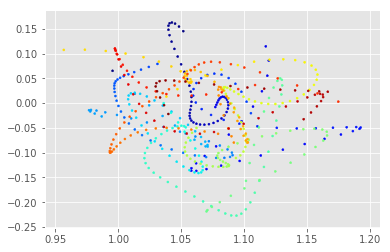

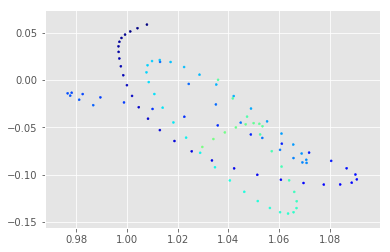

In [21]:
plt.style.use('ggplot')
plt.scatter(gains[0,39,0,30,:500].real, gains[0,39,0,30,:500].imag, s=4, c=plt.cm.jet(np.arange(500.)/500.))
plt.show()
plt.scatter(gains[0,39,0,30,100:200].real, gains[0,39,0,30,100:200].imag, s=4, c=plt.cm.jet(np.arange(100.)/200.))
plt.show()

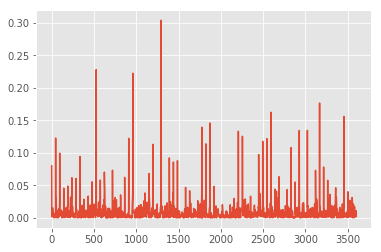

In [25]:
plt.plot(np.abs(gains[0,39,0,30,1:].imag - gains[0,39,0,30,:-1].imag))
plt.show()

In [ ]:
import 